In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import rankdata

import scipy.spatial
from itertools import combinations
from scipy.spatial.distance import pdist
from scipy import optimize

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

In [2]:
plt.style.use('ggplot')

In [3]:
locations = pd.read_csv('Data\stations.txt', sep=' ', index_col=0)

locations.head(20)

database  station_latitude(dec.degree)  \
station_name                                             
TILLABERI     AMMA-CATCH                     14.204300   
TOBRE         AMMA-CATCH                     10.199100   
TARA          AMMA-CATCH                     15.251400   
AGOUFOU       AMMA-CATCH                     15.360000   
LAWRA            MARLOES                     10.866670   
NAVRONGO         MARLOES                     10.530000   
OUAHIGOUYA       MARLOES                     13.520000   
TAMALE           MARLOES                      9.330000   
WA               MARLOES                     10.030000   
ZUARUNGU         MARLOES                     10.783300   
ANIABISI          WASCAL                     10.847251   
POUDRI            WASCAL                     10.913934   
LARE              WASCAL                     11.192883   
YABOGANE          WASCAL                     11.261641   

              station_longitude(dec.degree)  station_altitude(m)  
station_name                                                      
TILLABERI                          1.454500                212.0  
TOBRE                              2.133500                371.0  
TARA                              -1.585500                335.0  
AGOUFOU                           -1.470000                340.0  
LAWRA                             -1.483330                305.0  
NAVRONGO                          -1.050000                201.3  
OUAHIGOUYA                        -2.390000                365.0  
TAMALE                            -0.510000                183.3  
WA                                -2.090000                322.7  
ZUARUNGU                          -0.800000                235.0  
ANIABISI                          -0.910629                220.0  
POUDRI                             1.111897                190.0  
LARE                              -3.095351                320.0  
YABOGANE                          -2.968168                305.0

## Next, we are going to merge the 1-pixel satelite products with the gauge measurements only at the dates that both values are measured: TRAINING DATA

In [4]:
# load the .csv 

TILLABERIsat1 = pd.read_csv("OrganisedData\MSWEP\TILLABERIsat1.csv", index_col=0)
TOBREsat1 = pd.read_csv("OrganisedData\MSWEP\TOBREsat1.csv", index_col=0)
TARAsat1 = pd.read_csv("OrganisedData\MSWEP\TARAsat1.csv", index_col=0)
AGOUFOUsat1 = pd.read_csv("OrganisedData\MSWEP\AGOUFOUsat1.csv", index_col=0)
LAWRAsat1 = pd.read_csv("OrganisedData\MSWEP\LAWRAsat1.csv", index_col=0)
NAVRONGOsat1 = pd.read_csv("OrganisedData\MSWEP\\NAVRONGOsat1.csv", index_col=0)
OUAHIGOUYAsat1 = pd.read_csv("OrganisedData\MSWEP\OUAHIGOUYAsat1.csv", index_col=0)
TAMALEsat1 = pd.read_csv("OrganisedData\MSWEP\TAMALEsat1.csv", index_col=0)
WAsat1 = pd.read_csv("OrganisedData\MSWEP\WAsat1.csv", index_col=0)
ZUARUNGUsat1 = pd.read_csv("OrganisedData\MSWEP\ZUARUNGUsat1.csv", index_col=0)
ANIABISIsat1 = pd.read_csv("OrganisedData\MSWEP\ANIABISIsat1.csv", index_col=0)
POUDRIsat1 = pd.read_csv("OrganisedData\MSWEP\POUDRIsat1.csv", index_col=0)
LAREsat1 = pd.read_csv("OrganisedData\MSWEP\LAREsat1.csv", index_col=0)
YABOGANEsat1 = pd.read_csv("OrganisedData\MSWEP\YABOGANEsat1.csv", index_col=0)

# ZUARUNGUsat1.head(10000)

## Loading the gauge measurements, one has to make sure that: (a) the dates have no time (even discarded manually) and (b) the values have been loaded.

In [5]:
# load the time-series 

TILLABERI = pd.read_csv("OrganisedData\Gauges\stationTILLABERI.csv", index_col=0)
TOBRE = pd.read_csv("OrganisedData\Gauges\stationTOBRE.csv", index_col=0)
TARA = pd.read_csv("OrganisedData\Gauges\stationTARA.csv", index_col=0)
AGOUFOU = pd.read_csv("OrganisedData\Gauges\stationAGOUFOU.csv", index_col=0)
LAWRA = pd.read_csv("OrganisedData\Gauges\stationLAWRA.csv", index_col=0)
NAVRONGO = pd.read_csv("OrganisedData\Gauges\\stationNAVRONGO.csv", index_col=0)
OUAHIGOUYA = pd.read_csv("OrganisedData\Gauges\stationOUAHIGOUYA.csv", index_col=0)
TAMALE = pd.read_csv("OrganisedData\Gauges\stationTAMALE.csv", index_col=0)
WA = pd.read_csv("OrganisedData\Gauges\stationWA.csv", index_col=0)
ZUARUNGU = pd.read_csv("OrganisedData\Gauges\stationZUARUNGU.csv", index_col=0)
ANIABISI = pd.read_csv("OrganisedData\Gauges\stationANIABISI.csv", index_col=0)
POUDRI = pd.read_csv("OrganisedData\Gauges\stationPOUDRI.csv", index_col=0)
LARE = pd.read_csv("OrganisedData\Gauges\stationLARE.csv", index_col=0)
YABOGANE = pd.read_csv("OrganisedData\Gauges\stationYABOGANE.csv", index_col=0)

# AGOUFOU.head(10000)

# TRAINING DATA

# 1. TILLABERI

In [6]:
TILLABERItrain = TILLABERI.merge(TILLABERIsat1, how='left', left_on=TILLABERI.index, right_on=TILLABERIsat1.index)
TILLABERItrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
TILLABERItrain.set_index('Date', inplace=True)

TILLABERItrain.index = pd.to_datetime(TILLABERItrain.index, errors='coerce')

In [7]:
# TILLABERItrain

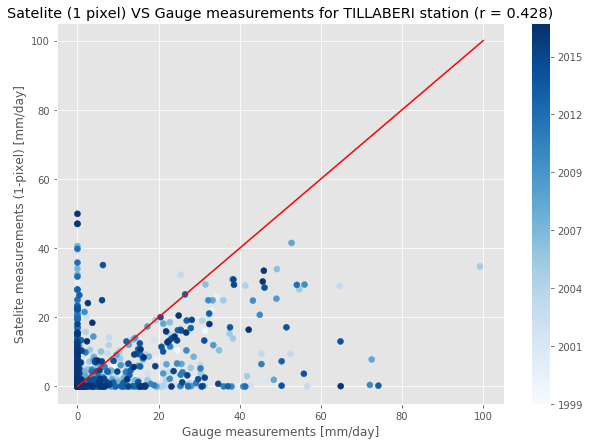

In [8]:
# correlation estimation

rho = TILLABERItrain['g[mm]'].corr(TILLABERItrain['sat[mm]'])

# plotrho = TILLABERItrain['g[mm]'].corr(TILLABERItrain['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(TILLABERItrain['g[mm]'], TILLABERItrain['sat[mm]'], c=range(len(TILLABERItrain.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = TILLABERItrain.index.year[np.arange(0, len(TILLABERItrain), 1000)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (1 pixel) VS Gauge measurements for TILLABERI station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge measurements for TILLABERI station.png');

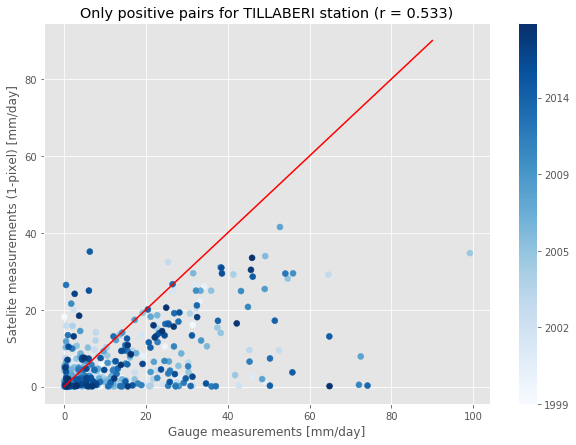

In [9]:
TILLABERItrainPOS = TILLABERItrain[(TILLABERItrain['g[mm]'] > 0.0) & (TILLABERItrain['sat[mm]'] > 0.0)]

rho = TILLABERItrainPOS['g[mm]'].corr(TILLABERItrainPOS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(TILLABERItrainPOS['g[mm]'], TILLABERItrainPOS['sat[mm]'], c=range(len(TILLABERItrainPOS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = TILLABERItrainPOS.index.year[np.arange(0, len(TILLABERItrainPOS), 100)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive pairs for TILLABERI station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge ONLY POSITIVE PAIRS measurements for TILLABERI station.png');

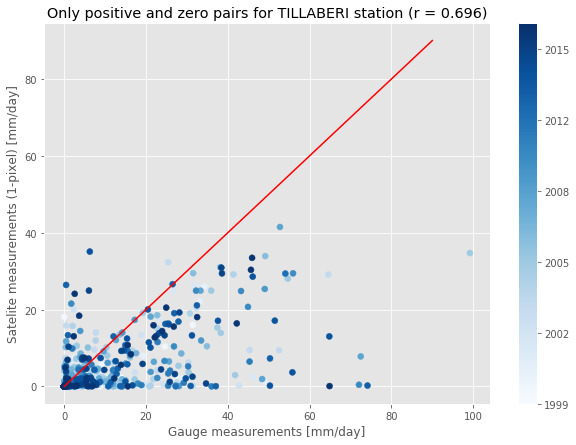

In [10]:
TILLABERItrainPOSandZEROS = TILLABERItrain[((TILLABERItrain['g[mm]'] > 0.0) & (TILLABERItrain['sat[mm]'] > 0.0))  |  ((TILLABERItrain['g[mm]'] == 0.0) & (TILLABERItrain['sat[mm]'] == 0.0))]

rho = TILLABERItrainPOSandZEROS['g[mm]'].corr(TILLABERItrainPOSandZEROS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(TILLABERItrainPOSandZEROS['g[mm]'], TILLABERItrainPOSandZEROS['sat[mm]'], c=range(len(TILLABERItrainPOSandZEROS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = TILLABERItrainPOSandZEROS.index.year[np.arange(0, len(TILLABERItrainPOSandZEROS), 1000)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive and zero pairs for TILLABERI station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge ONLY POSITIVE AND ZERO PAIRS measurements for TILLABERI station.png');

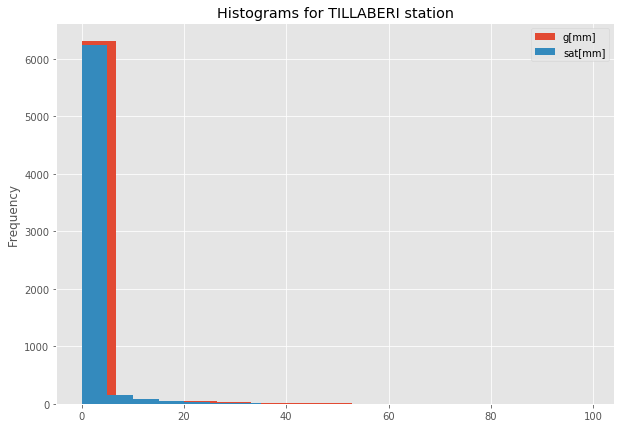

In [78]:
plt.figure(figsize=(10, 7))

TILLABERItrain['g[mm]'].plot.hist(bins = 15)
TILLABERItrain['sat[mm]'].plot.hist(bins = 10)

plt.legend()

plt.title(f'Histograms for TILLABERI station');

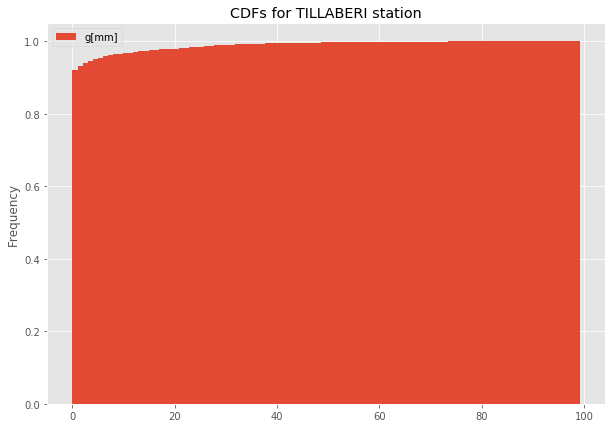

In [79]:
plt.figure(figsize=(10, 7))

TILLABERItrain['g[mm]'].plot.hist(cumulative=True, density=1, bins=100)
# TILLABERItrain['sat[mm]'].plot.hist(cumulative=True, density=1, bins=100)

plt.legend()

plt.title(f'CDFs for TILLABERI station');

# .hist(cumulative=True, density=1, bins=100)

In [11]:
TILLABERItrain.to_csv("OrganisedData\TrainingData\TILLABERItrain.csv")

# Let's now plot the 3-day sums

In [32]:
TILLABERI_3d = pd.DataFrame()

TILLABERI_3d['g[mm]'] = TILLABERItrain['g[mm]'].resample(rule = '3d').sum()
TILLABERI_3d['sat[mm]'] = TILLABERItrain['sat[mm]'].resample(rule = '3d').sum()

TILLABERI_3d

g[mm]  sat[mm]
Date                      
1999-01-01    0.0      0.0
1999-01-04    0.0      0.0
1999-01-07    0.0      0.0
1999-01-10    0.0      0.0
1999-01-13    0.0      0.0
...           ...      ...
2016-12-18    0.0      0.0
2016-12-21    0.0      0.0
2016-12-24    0.0      0.0
2016-12-27    0.0      0.0
2016-12-30    0.0      0.0

[2192 rows x 2 columns]

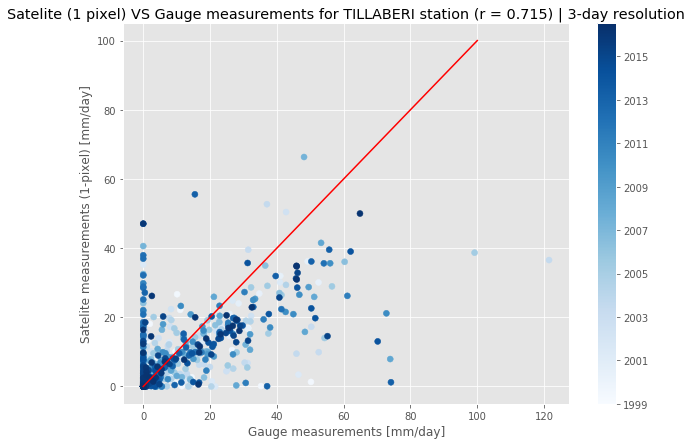

In [33]:
# correlation estimation

rho = TILLABERI_3d['g[mm]'].corr(TILLABERI_3d['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(TILLABERI_3d['g[mm]'], TILLABERI_3d['sat[mm]'], c=range(len(TILLABERI_3d.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = TILLABERI_3d.index.year[np.arange(0, len(TILLABERI_3d), 250)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (1 pixel) VS Gauge measurements for TILLABERI station (r = {rho:.3f}) | 3-day resolution')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge measurements for TILLABERI station (3-day resolution).png');

In [35]:
TILLABERI_2d = pd.DataFrame()

TILLABERI_2d['g[mm]'] = TILLABERItrain['g[mm]'].resample(rule = '2d').sum()
TILLABERI_2d['sat[mm]'] = TILLABERItrain['sat[mm]'].resample(rule = '2d').sum()

# TILLABERI_2d

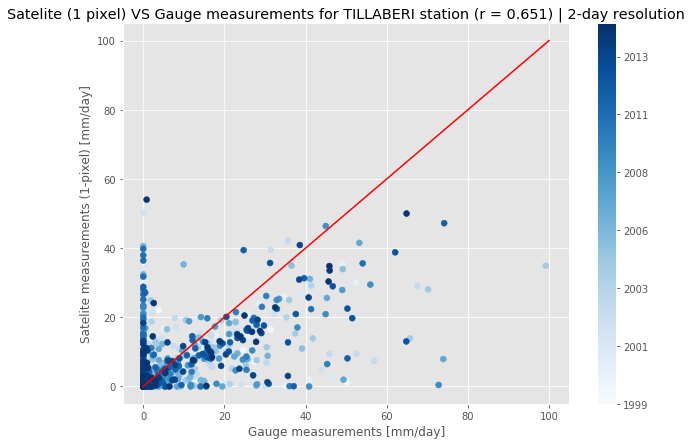

In [36]:
# correlation estimation

rho = TILLABERI_2d['g[mm]'].corr(TILLABERI_2d['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(TILLABERI_2d['g[mm]'], TILLABERI_2d['sat[mm]'], c=range(len(TILLABERI_2d.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = TILLABERI_2d.index.year[np.arange(0, len(TILLABERI_2d), 450)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (1 pixel) VS Gauge measurements for TILLABERI station (r = {rho:.3f}) | 2-day resolution')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge measurements for TILLABERI station (2-day resolution).png');

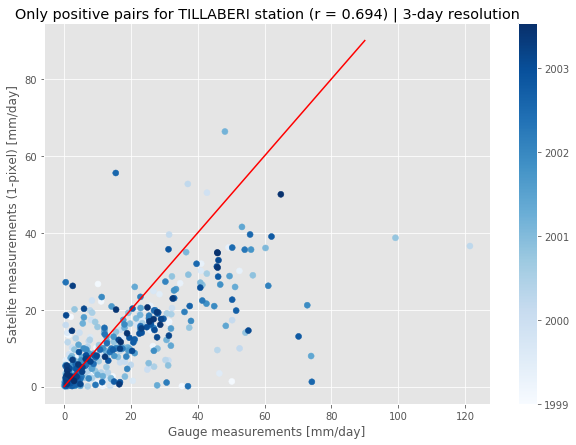

In [37]:
TILLABERI_3dPOS = TILLABERI_3d[(TILLABERI_3d['g[mm]'] > 0.0) & (TILLABERI_3d['sat[mm]'] > 0.0)]

rho = TILLABERI_3dPOS['g[mm]'].corr(TILLABERI_3dPOS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(TILLABERI_3dPOS['g[mm]'], TILLABERI_3dPOS['sat[mm]'], c=range(len(TILLABERI_3dPOS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = TILLABERI_3dPOS.index.year[np.arange(0, len(TILLABERI_3dPOS), 30)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive pairs for TILLABERI station (r = {rho:.3f}) | 3-day resolution')

plt.savefig('DataFigures/ONLY POSITIVE PAIRS measurements for TILLABERI station (3-day resolution).png');

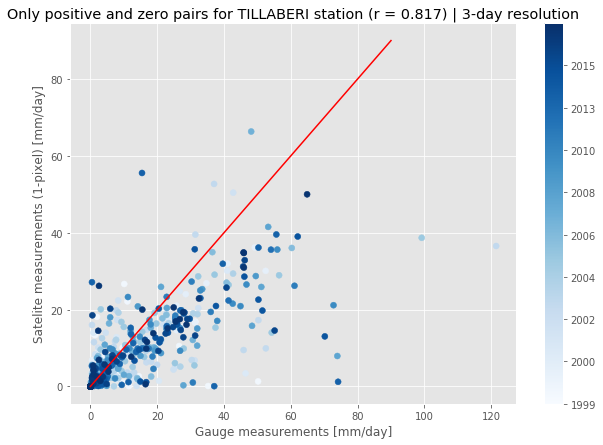

In [84]:
TILLABERI_3dPOSandZEROS = TILLABERI_3d[((TILLABERI_3d['g[mm]'] > 0.0) & (TILLABERI_3d['sat[mm]'] > 0.0))  |  ((TILLABERI_3d['g[mm]'] == 0.0) & (TILLABERI_3d['sat[mm]'] == 0.0))]

rho = TILLABERI_3dPOSandZEROS['g[mm]'].corr(TILLABERI_3dPOSandZEROS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(TILLABERI_3dPOSandZEROS['g[mm]'], TILLABERI_3dPOSandZEROS['sat[mm]'], c=range(len(TILLABERI_3dPOSandZEROS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = TILLABERI_3dPOSandZEROS.index.year[np.arange(0, len(TILLABERI_3dPOSandZEROS), 200)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive and zero pairs for TILLABERI station (r = {rho:.3f}) | 3-day resolution')

plt.savefig('DataFigures/ONLY POSITIVE AND ZERO PAIRS measurements for TILLABERI station (3-day resolution).png');

# 2. TOBRE

In [40]:
TOBREtrain = TOBRE.merge(TOBREsat1, how='left', left_on=TOBRE.index, right_on=TOBREsat1.index)
TOBREtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
TOBREtrain.set_index('Date', inplace=True)

In [41]:
TOBREtrain = TOBREtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

TOBREtrain.index = pd.to_datetime(TOBREtrain.index, errors='coerce')

# TOBREtrain

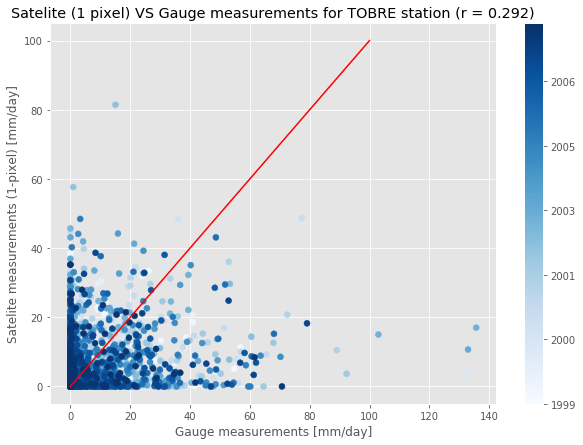

In [42]:
rho = TOBREtrain['g[mm]'].corr(TOBREtrain['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(TOBREtrain['g[mm]'], TOBREtrain['sat[mm]'], c=range(len(TOBREtrain.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = TOBREtrain.index.year[np.arange(0, len(TOBREtrain), 500)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (1 pixel) VS Gauge measurements for TOBRE station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge measurements for TOBRE station.png');

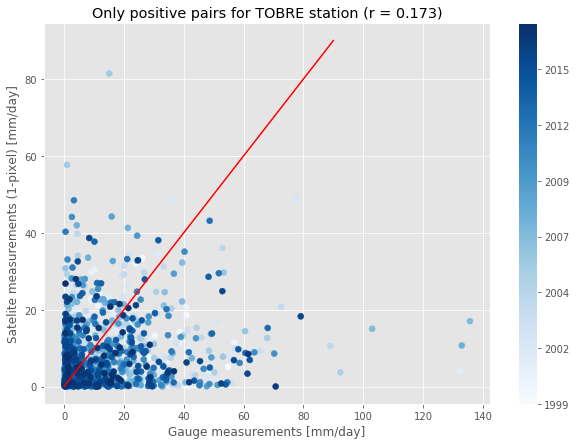

In [43]:
TOBREtrainPOS = TOBREtrain[(TOBREtrain['g[mm]'] > 0.0) & (TOBREtrain['sat[mm]'] > 0.0)]

rho = TOBREtrainPOS['g[mm]'].corr(TOBREtrainPOS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(TOBREtrainPOS['g[mm]'], TOBREtrainPOS['sat[mm]'], c=range(len(TOBREtrainPOS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = TOBREtrainPOS.index.year[np.arange(0, len(TOBREtrainPOS), 200)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive pairs for TOBRE station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge ONLY POSITIVE PAIRS measurements for TOBRE station.png');

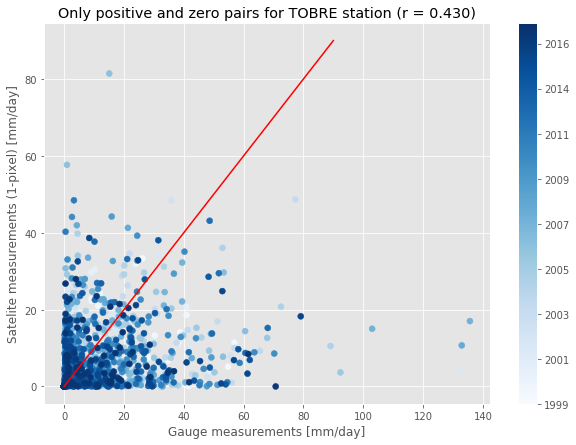

In [44]:
TOBREtrainPOSandZEROS = TOBREtrain[((TOBREtrain['g[mm]'] > 0.0) & (TOBREtrain['sat[mm]'] > 0.0))  |  ((TOBREtrain['g[mm]'] == 0.0) & (TOBREtrain['sat[mm]'] == 0.0))]

rho = TOBREtrainPOSandZEROS['g[mm]'].corr(TOBREtrainPOSandZEROS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(TOBREtrainPOSandZEROS['g[mm]'], TOBREtrainPOSandZEROS['sat[mm]'], c=range(len(TOBREtrainPOSandZEROS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = TOBREtrainPOSandZEROS.index.year[np.arange(0, len(TOBREtrainPOSandZEROS), 500)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive and zero pairs for TOBRE station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge ONLY POSITIVE AND ZERO PAIRS measurements for TOBRE station.png');

In [45]:
TOBREtrain.to_csv("OrganisedData\TrainingData\TOBREtrain.csv")

# 3. TARA

In [46]:
TARAtrain = TARA.merge(TARAsat1, how='left', left_on=TARA.index, right_on=TARAsat1.index)
TARAtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
TARAtrain.set_index('Date', inplace=True)

TARAtrain = TARAtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

TARAtrain.index = pd.to_datetime(TARAtrain.index, errors='coerce')

TARAtrain.to_csv("OrganisedData\TrainingData\TARAtrain.csv")

# TARAtrain

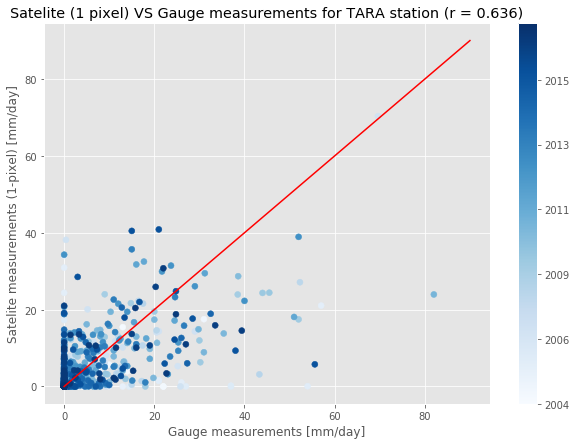

In [47]:
# correlation estimation

rho = TARAtrain['g[mm]'].corr(TARAtrain['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(TARAtrain['g[mm]'], TARAtrain['sat[mm]'], c=range(len(TARAtrain.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = TARAtrain.index.year[np.arange(0, len(TARAtrain), 500)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (1 pixel) VS Gauge measurements for TARA station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge measurements for TARA station.png');

### Tara station only positives

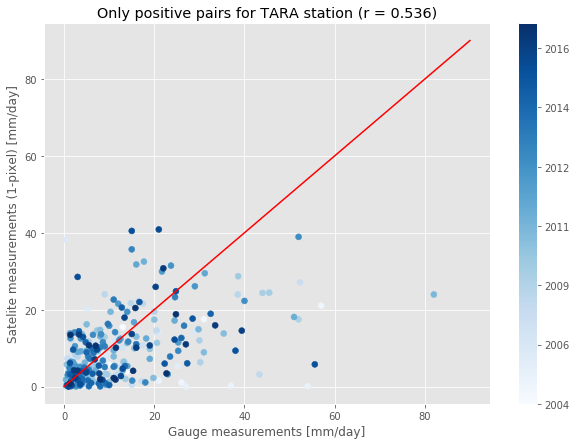

In [48]:
TARAtrainPOS = TARAtrain[(TARAtrain['g[mm]'] > 0.0) & (TARAtrain['sat[mm]'] > 0.0)]

rho = TARAtrainPOS['g[mm]'].corr(TARAtrainPOS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(TARAtrainPOS['g[mm]'], TARAtrainPOS['sat[mm]'], c=range(len(TARAtrainPOS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = TARAtrainPOS.index.year[np.arange(0, len(TARAtrainPOS), 50)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive pairs for TARA station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge ONLY POSITIVE PAIRS measurements for TARA station.png');

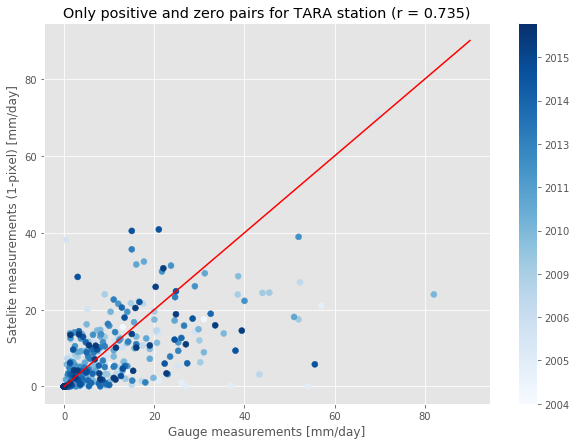

In [49]:
TARAtrainPOSandZEROS = TARAtrain[((TARAtrain['g[mm]'] > 0.0) & (TARAtrain['sat[mm]'] > 0.0))  |  ((TARAtrain['g[mm]'] == 0.0) & (TARAtrain['sat[mm]'] == 0.0))]

rho = TARAtrainPOSandZEROS['g[mm]'].corr(TARAtrainPOSandZEROS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(TARAtrainPOSandZEROS['g[mm]'], TARAtrainPOSandZEROS['sat[mm]'], c=range(len(TARAtrainPOSandZEROS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = TARAtrainPOSandZEROS.index.year[np.arange(0, len(TARAtrainPOSandZEROS), 250)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive and zero pairs for TARA station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge ONLY POSITIVE AND ZERO PAIRS measurements for TARA station.png');

### without clear outliers

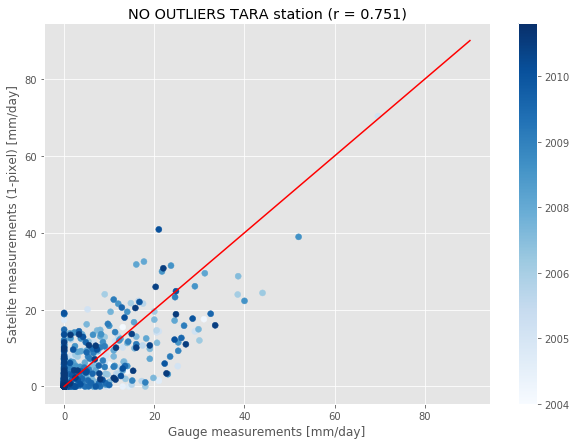

In [50]:
TARAtrainPOSandZEROS = TARAtrain[(np.absolute(TARAtrain['g[mm]'] - TARAtrain['sat[mm]']) < 20.0)]

rho = TARAtrainPOSandZEROS['g[mm]'].corr(TARAtrainPOSandZEROS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(TARAtrainPOSandZEROS['g[mm]'], TARAtrainPOSandZEROS['sat[mm]'], c=range(len(TARAtrainPOSandZEROS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = TARAtrainPOSandZEROS.index.year[np.arange(0, len(TARAtrainPOSandZEROS), 250)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'NO OUTLIERS TARA station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge NO OUTLIERS measurements for TARA station.png');

In [52]:
TARA_3d = pd.DataFrame()

TARA_3d['g[mm]'] = TARAtrain['g[mm]'].resample(rule = '3d').sum()
TARA_3d['sat[mm]'] = TARAtrain['sat[mm]'].resample(rule = '3d').sum()

# TARA_3d

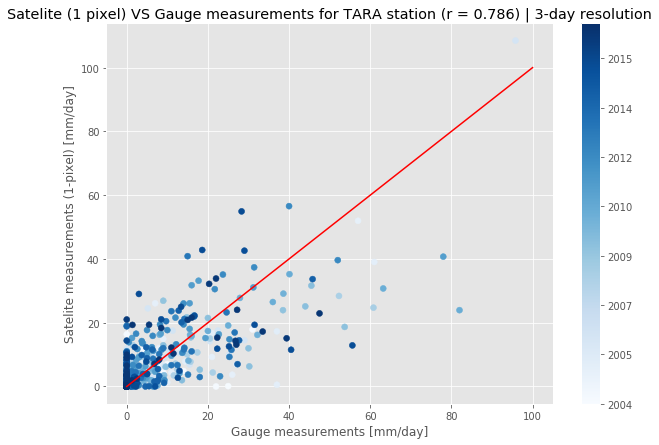

In [56]:
# correlation estimation

rho = TARA_3d['g[mm]'].corr(TARA_3d['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(TARA_3d['g[mm]'], TARA_3d['sat[mm]'], c=range(len(TARA_3d.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = TARA_3d.index.year[np.arange(0, len(TARA_3d), 200)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (1 pixel) VS Gauge measurements for TARA station (r = {rho:.3f}) | 3-day resolution')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge measurements for TARA station (3-day resolution).png');

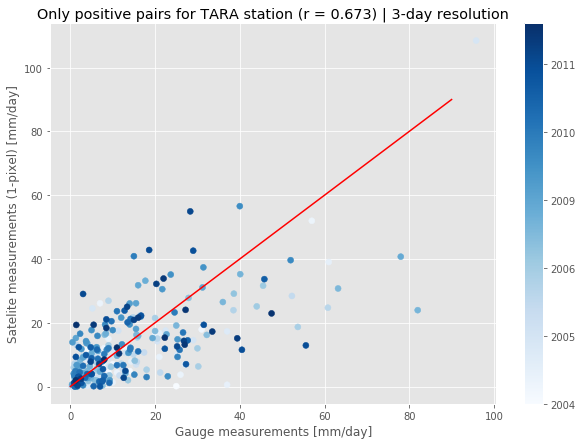

In [57]:
TARA_3dPOS = TARA_3d[(TARA_3d['g[mm]'] > 0.0) & (TARA_3d['sat[mm]'] > 0.0)]

rho = TARA_3dPOS['g[mm]'].corr(TARA_3dPOS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(TARA_3dPOS['g[mm]'], TARA_3dPOS['sat[mm]'], c=range(len(TARA_3dPOS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = TARA_3dPOS.index.year[np.arange(0, len(TARA_3dPOS), 30)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive pairs for TARA station (r = {rho:.3f}) | 3-day resolution')

plt.savefig('DataFigures/ONLY POSITIVE PAIRS measurements for TARA station (3-day resolution).png');

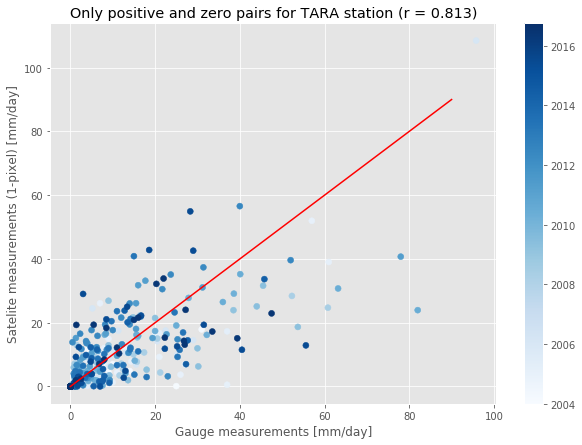

In [58]:
TARA_3dPOSandZEROS = TARA_3d[((TARA_3d['g[mm]'] > 0.0) & (TARA_3d['sat[mm]'] > 0.0))  |  ((TARA_3d['g[mm]'] == 0.0) & (TARA_3d['sat[mm]'] == 0.0))]

rho = TARA_3dPOSandZEROS['g[mm]'].corr(TARA_3dPOSandZEROS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(TARA_3dPOSandZEROS['g[mm]'], TARA_3dPOSandZEROS['sat[mm]'], c=range(len(TARA_3dPOSandZEROS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = TARA_3dPOSandZEROS.index.year[np.arange(0, len(TARA_3dPOSandZEROS), 200)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive and zero pairs for TARA station (r = {rho:.3f})')

plt.savefig('DataFigures/ONLY POSITIVE AND ZERO PAIRS measurements for TARA station (3-day resolution).png');

# 4. AGOUFOU

In [33]:
AGOUFOUtrain = AGOUFOU.merge(AGOUFOUsat1, how='left', left_on=AGOUFOU.index, right_on=AGOUFOUsat1.index)
AGOUFOUtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
AGOUFOUtrain.set_index('Date', inplace=True)

AGOUFOUtrain = AGOUFOUtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

AGOUFOUtrain.index = pd.to_datetime(AGOUFOUtrain.index, errors='coerce')

AGOUFOUtrain.to_csv("OrganisedData\TrainingData\AGOUFOUtrain.csv")

# AGOUFOUtrain

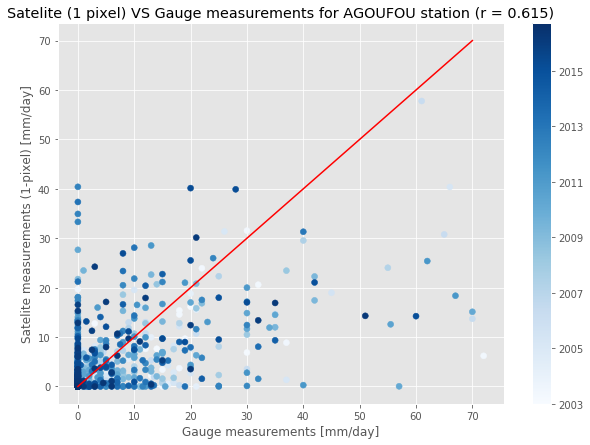

In [34]:
# correlation estimation

rho = AGOUFOUtrain['g[mm]'].corr(AGOUFOUtrain['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(AGOUFOUtrain['g[mm]'], AGOUFOUtrain['sat[mm]'], c=range(len(AGOUFOUtrain.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 70, 2), np.linspace(0, 70, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = AGOUFOUtrain.index.year[np.arange(0, len(AGOUFOUtrain), 500)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (1 pixel) VS Gauge measurements for AGOUFOU station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge measurements for AGOUFOU station.png');

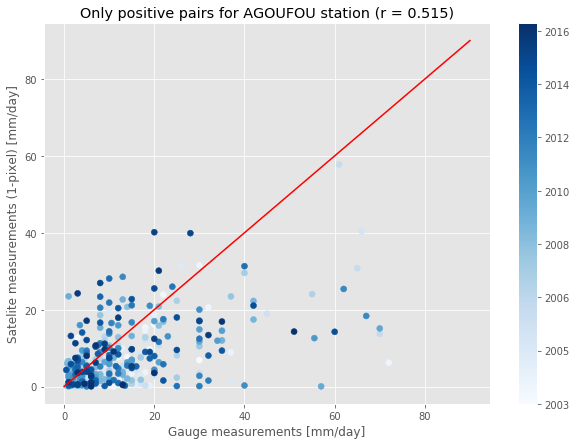

In [35]:
AGOUFOUtrainPOS = AGOUFOUtrain[(AGOUFOUtrain['g[mm]'] > 0.0) & (AGOUFOUtrain['sat[mm]'] > 0.0)]

rho = AGOUFOUtrainPOS['g[mm]'].corr(AGOUFOUtrainPOS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(AGOUFOUtrainPOS['g[mm]'], AGOUFOUtrainPOS['sat[mm]'], c=range(len(AGOUFOUtrainPOS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = AGOUFOUtrainPOS.index.year[np.arange(0, len(AGOUFOUtrainPOS), 50)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive pairs for AGOUFOU station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge ONLY POSITIVE PAIRS measurements for AGOUFOU station.png');

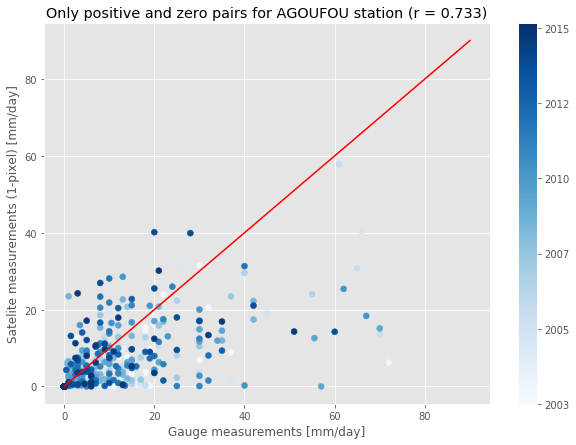

In [37]:
AGOUFOUtrainPOSandZEROS = AGOUFOUtrain[((AGOUFOUtrain['g[mm]'] > 0.0) & (AGOUFOUtrain['sat[mm]'] > 0.0))  |  ((AGOUFOUtrain['g[mm]'] == 0.0) & (AGOUFOUtrain['sat[mm]'] == 0.0))]

rho = AGOUFOUtrainPOSandZEROS['g[mm]'].corr(AGOUFOUtrainPOSandZEROS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(AGOUFOUtrainPOSandZEROS['g[mm]'], AGOUFOUtrainPOSandZEROS['sat[mm]'], c=range(len(AGOUFOUtrainPOSandZEROS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = AGOUFOUtrainPOSandZEROS.index.year[np.arange(0, len(AGOUFOUtrainPOSandZEROS), 450)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive and zero pairs for AGOUFOU station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge ONLY POSITIVE AND ZERO PAIRS measurements for AGOUFOU station.png');

# 5. LAWRA

In [38]:
LAWRAtrain = LAWRA.merge(LAWRAsat1, how='left', left_on=LAWRA.index, right_on=LAWRAsat1.index)
LAWRAtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
LAWRAtrain.set_index('Date', inplace=True)

LAWRAtrain = LAWRAtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

LAWRAtrain.index = pd.to_datetime(LAWRAtrain.index, errors='coerce')

LAWRAtrain.to_csv("OrganisedData\TrainingData\LAWRAtrain.csv")

# LAWRAtrain

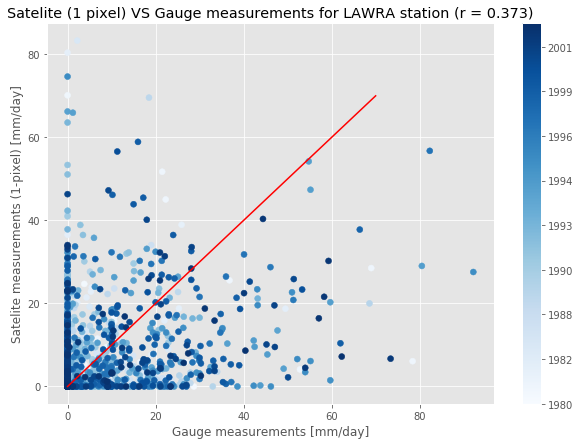

In [39]:
rho = LAWRAtrain['g[mm]'].corr(LAWRAtrain['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(LAWRAtrain['g[mm]'], LAWRAtrain['sat[mm]'], c=range(len(LAWRAtrain.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 70, 2), np.linspace(0, 70, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = LAWRAtrain.index.year[np.arange(0, len(LAWRAtrain), 500)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (1 pixel) VS Gauge measurements for LAWRA station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge measurements for LAWRA station.png');

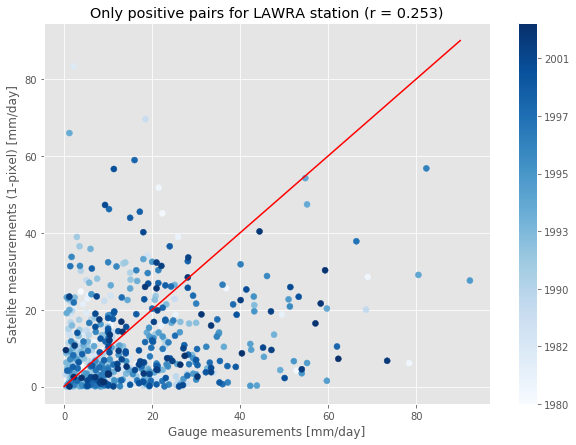

In [40]:
LAWRAtrainPOS = LAWRAtrain[(LAWRAtrain['g[mm]'] > 0.0) & (LAWRAtrain['sat[mm]'] > 0.0)]

rho = LAWRAtrainPOS['g[mm]'].corr(LAWRAtrainPOS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(LAWRAtrainPOS['g[mm]'], LAWRAtrainPOS['sat[mm]'], c=range(len(LAWRAtrainPOS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = LAWRAtrainPOS.index.year[np.arange(0, len(LAWRAtrainPOS), 100)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive pairs for LAWRA station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge ONLY POSITIVE PAIRS measurements for LAWRA station.png');

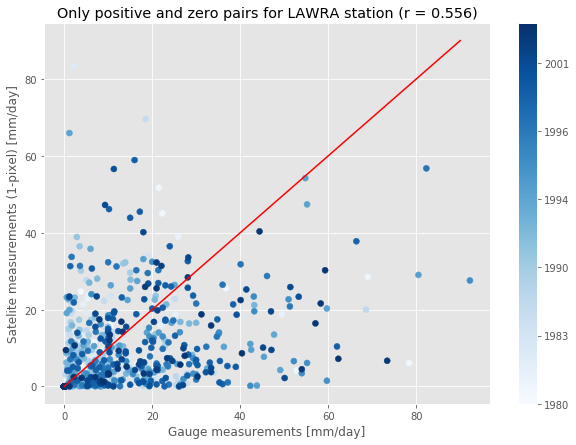

In [41]:
LAWRAtrainPOSandZEROS = LAWRAtrain[((LAWRAtrain['g[mm]'] > 0.0) & (LAWRAtrain['sat[mm]'] > 0.0))  |  ((LAWRAtrain['g[mm]'] == 0.0) & (LAWRAtrain['sat[mm]'] == 0.0))]

rho = LAWRAtrainPOSandZEROS['g[mm]'].corr(LAWRAtrainPOSandZEROS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(LAWRAtrainPOSandZEROS['g[mm]'], LAWRAtrainPOSandZEROS['sat[mm]'], c=range(len(LAWRAtrainPOSandZEROS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = LAWRAtrainPOSandZEROS.index.year[np.arange(0, len(LAWRAtrainPOSandZEROS), 500)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive and zero pairs for LAWRA station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge ONLY POSITIVE AND ZERO PAIRS measurements for LAWRA station.png');

# 6. NAVRONGO

In [42]:
NAVRONGOtrain = NAVRONGO.merge(NAVRONGOsat1, how='left', left_on=NAVRONGO.index, right_on=NAVRONGOsat1.index)
NAVRONGOtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
NAVRONGOtrain.set_index('Date', inplace=True)

NAVRONGOtrain = NAVRONGOtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

NAVRONGOtrain.index = pd.to_datetime(NAVRONGOtrain.index, errors='coerce')

NAVRONGOtrain.to_csv("OrganisedData\TrainingData\\NAVRONGOtrain.csv")

# NAVRONGOtrain

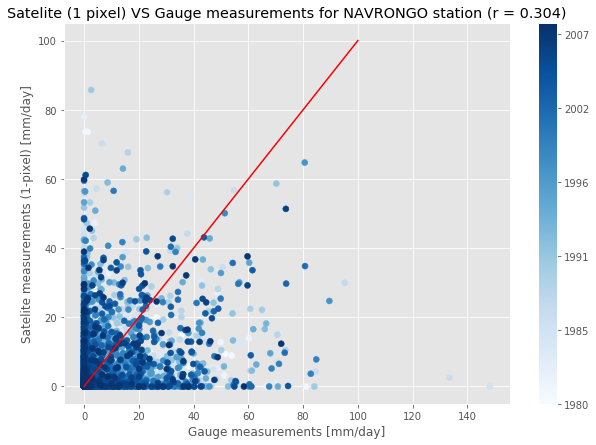

In [43]:
rho = NAVRONGOtrain['g[mm]'].corr(NAVRONGOtrain['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(NAVRONGOtrain['g[mm]'], NAVRONGOtrain['sat[mm]'], c=range(len(NAVRONGOtrain.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = NAVRONGOtrain.index.year[np.arange(0, len(NAVRONGOtrain), 2000)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (1 pixel) VS Gauge measurements for NAVRONGO station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge measurements for NAVRONGO station.png');

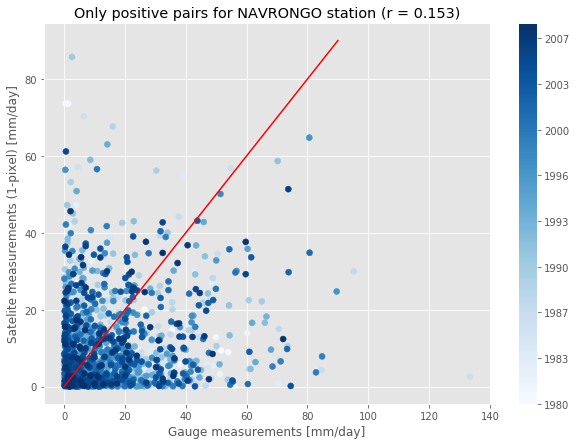

In [44]:
NAVRONGOtrainPOS = NAVRONGOtrain[(NAVRONGOtrain['g[mm]'] > 0.0) & (NAVRONGOtrain['sat[mm]'] > 0.0)]

rho = NAVRONGOtrainPOS['g[mm]'].corr(NAVRONGOtrainPOS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(NAVRONGOtrainPOS['g[mm]'], NAVRONGOtrainPOS['sat[mm]'], c=range(len(NAVRONGOtrainPOS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = NAVRONGOtrainPOS.index.year[np.arange(0, len(NAVRONGOtrainPOS), 200)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive pairs for NAVRONGO station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge ONLY POSITIVE PAIRS measurements for NAVRONGO station.png');

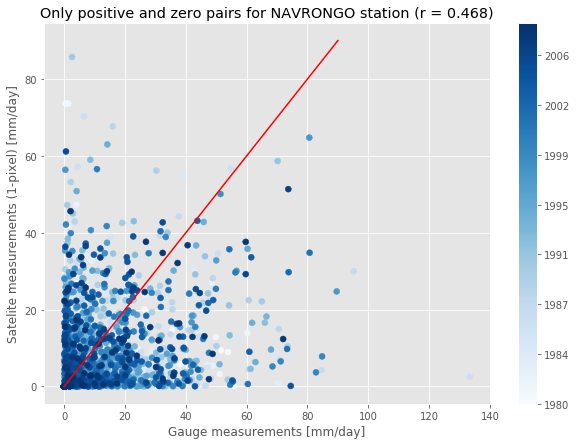

In [45]:
NAVRONGOtrainPOSandZEROS = NAVRONGOtrain[((NAVRONGOtrain['g[mm]'] > 0.0) & (NAVRONGOtrain['sat[mm]'] > 0.0))  |  ((NAVRONGOtrain['g[mm]'] == 0.0) & (NAVRONGOtrain['sat[mm]'] == 0.0))]

rho = NAVRONGOtrainPOSandZEROS['g[mm]'].corr(NAVRONGOtrainPOSandZEROS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(NAVRONGOtrainPOSandZEROS['g[mm]'], NAVRONGOtrainPOSandZEROS['sat[mm]'], c=range(len(NAVRONGOtrainPOSandZEROS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = NAVRONGOtrainPOSandZEROS.index.year[np.arange(0, len(NAVRONGOtrainPOSandZEROS), 1000)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive and zero pairs for NAVRONGO station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge ONLY POSITIVE AND ZERO PAIRS measurements for NAVRONGO station.png');

# 7. OUAHIGOUYA

In [46]:
OUAHIGOUYAtrain = OUAHIGOUYA.merge(OUAHIGOUYAsat1, how='left', left_on=OUAHIGOUYA.index, right_on=OUAHIGOUYAsat1.index)
OUAHIGOUYAtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
OUAHIGOUYAtrain.set_index('Date', inplace=True)

OUAHIGOUYAtrain = OUAHIGOUYAtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

OUAHIGOUYAtrain.index = pd.to_datetime(OUAHIGOUYAtrain.index, errors='coerce')

OUAHIGOUYAtrain.to_csv("OrganisedData\TrainingData\OUAHIGOUYAtrain.csv")

# OUAHIGOUYAtrain

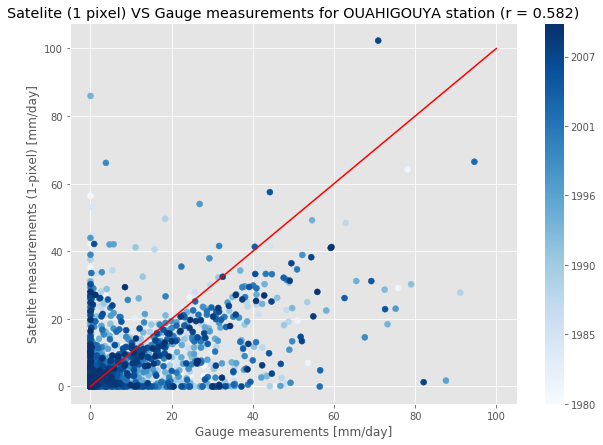

In [47]:
rho = OUAHIGOUYAtrain['g[mm]'].corr(OUAHIGOUYAtrain['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(OUAHIGOUYAtrain['g[mm]'], OUAHIGOUYAtrain['sat[mm]'], c=range(len(OUAHIGOUYAtrain.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = OUAHIGOUYAtrain.index.year[np.arange(0, len(OUAHIGOUYAtrain), 2000)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (1 pixel) VS Gauge measurements for OUAHIGOUYA station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge measurements for OUAHIGOUYA station.png');

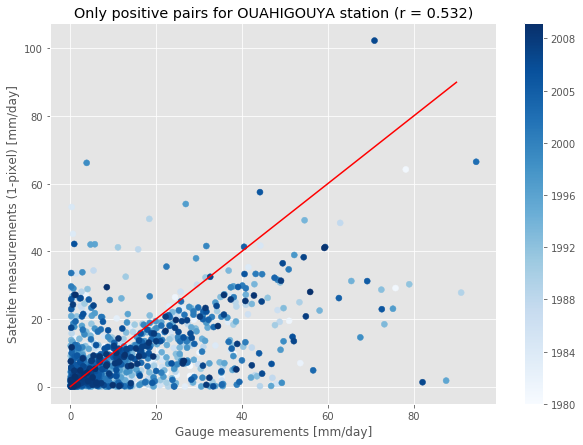

In [48]:
OUAHIGOUYAtrainPOS = OUAHIGOUYAtrain[(OUAHIGOUYAtrain['g[mm]'] > 0.0) & (OUAHIGOUYAtrain['sat[mm]'] > 0.0)]

rho = OUAHIGOUYAtrainPOS['g[mm]'].corr(OUAHIGOUYAtrainPOS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(OUAHIGOUYAtrainPOS['g[mm]'], OUAHIGOUYAtrainPOS['sat[mm]'], c=range(len(OUAHIGOUYAtrainPOS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = OUAHIGOUYAtrainPOS.index.year[np.arange(0, len(OUAHIGOUYAtrainPOS), 200)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive pairs for OUAHIGOUYA station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge ONLY POSITIVE PAIRS measurements for OUAHIGOUYA station.png');

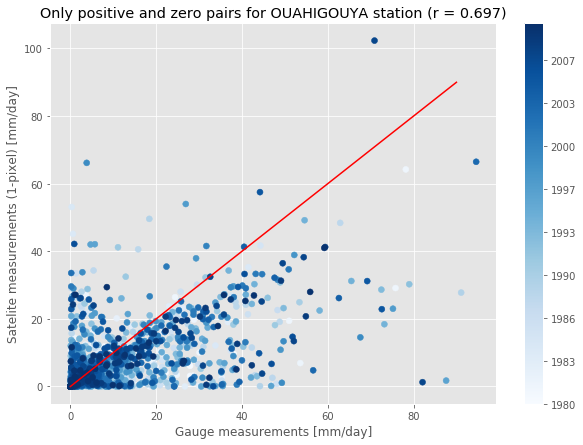

In [49]:
OUAHIGOUYAtrainPOSandZEROS = OUAHIGOUYAtrain[((OUAHIGOUYAtrain['g[mm]'] > 0.0) & (OUAHIGOUYAtrain['sat[mm]'] > 0.0))  |  ((OUAHIGOUYAtrain['g[mm]'] == 0.0) & (OUAHIGOUYAtrain['sat[mm]'] == 0.0))]

rho = OUAHIGOUYAtrainPOSandZEROS['g[mm]'].corr(OUAHIGOUYAtrainPOSandZEROS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(OUAHIGOUYAtrainPOSandZEROS['g[mm]'], OUAHIGOUYAtrainPOSandZEROS['sat[mm]'], c=range(len(OUAHIGOUYAtrainPOSandZEROS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = OUAHIGOUYAtrainPOSandZEROS.index.year[np.arange(0, len(OUAHIGOUYAtrainPOSandZEROS), 1000)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive and zero pairs for OUAHIGOUYA station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge ONLY POSITIVE AND ZERO PAIRS measurements for OUAHIGOUYA station.png');

# 8. TAMALE

In [50]:
TAMALEtrain = TAMALE.merge(TAMALEsat1, how='left', left_on=TAMALE.index, right_on=TAMALEsat1.index)
TAMALEtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
TAMALEtrain.set_index('Date', inplace=True)

TAMALEtrain = TAMALEtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

TAMALEtrain.index = pd.to_datetime(TAMALEtrain.index, errors='coerce')

TAMALEtrain.to_csv("OrganisedData\TrainingData\TAMALEtrain.csv")

# TAMALEtrain

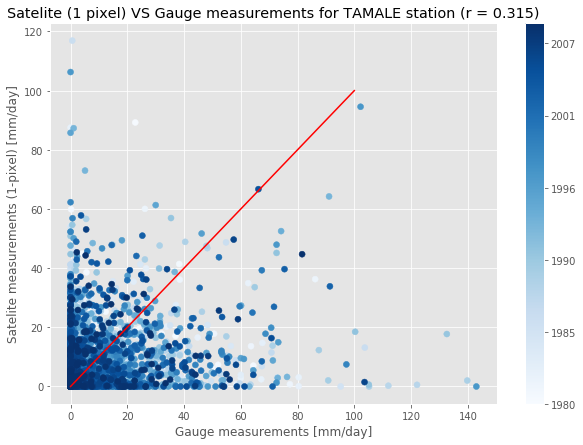

In [51]:
rho = TAMALEtrain['g[mm]'].corr(TAMALEtrain['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(TAMALEtrain['g[mm]'], TAMALEtrain['sat[mm]'], c=range(len(TAMALEtrain.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = TAMALEtrain.index.year[np.arange(0, len(TAMALEtrain), 2000)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (1 pixel) VS Gauge measurements for TAMALE station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge measurements for TAMALE station.png');

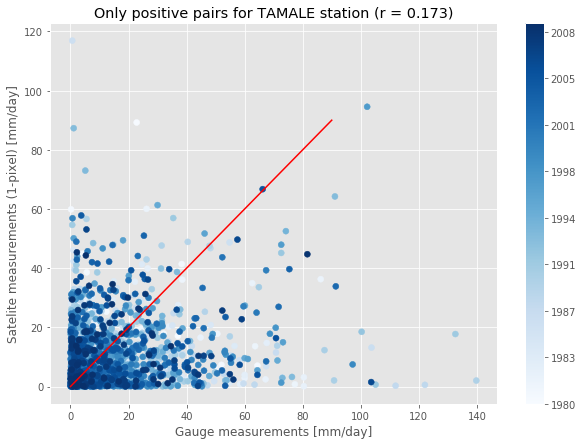

In [57]:
TAMALEtrainPOS = TAMALEtrain[(TAMALEtrain['g[mm]'] > 0.0) & (TAMALEtrain['sat[mm]'] > 0.0)]

rho = TAMALEtrainPOS['g[mm]'].corr(TAMALEtrainPOS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(TAMALEtrainPOS['g[mm]'], TAMALEtrainPOS['sat[mm]'], c=range(len(TAMALEtrainPOS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = TAMALEtrainPOS.index.year[np.arange(0, len(TAMALEtrainPOS), 250)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive pairs for TAMALE station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge ONLY POSITIVE PAIRS measurements for TAMALE station.png');

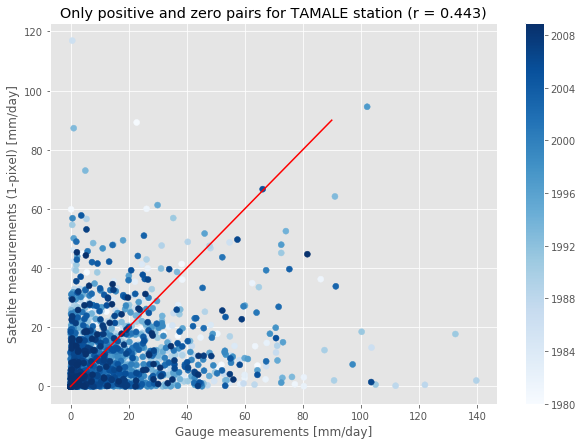

In [58]:
TAMALEtrainPOSandZEROS = TAMALEtrain[((TAMALEtrain['g[mm]'] > 0.0) & (TAMALEtrain['sat[mm]'] > 0.0))  |  ((TAMALEtrain['g[mm]'] == 0.0) & (TAMALEtrain['sat[mm]'] == 0.0))]

rho = TAMALEtrainPOSandZEROS['g[mm]'].corr(TAMALEtrainPOSandZEROS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(TAMALEtrainPOSandZEROS['g[mm]'], TAMALEtrainPOSandZEROS['sat[mm]'], c=range(len(TAMALEtrainPOSandZEROS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = TAMALEtrainPOSandZEROS.index.year[np.arange(0, len(TAMALEtrainPOSandZEROS), 1000)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive and zero pairs for TAMALE station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge ONLY POSITIVE AND ZERO PAIRS measurements for TAMALE station.png');

# 9. WA

In [59]:
WAtrain = WA.merge(WAsat1, how='left', left_on=WA.index, right_on=WAsat1.index)
WAtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
WAtrain.set_index('Date', inplace=True)

WAtrain = WAtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

WAtrain.index = pd.to_datetime(WAtrain.index, errors='coerce')

WAtrain.to_csv("OrganisedData\TrainingData\WAtrain.csv")

# WAtrain

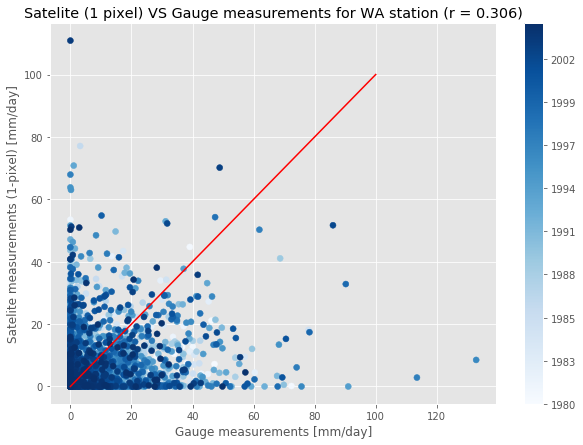

In [60]:
rho = WAtrain['g[mm]'].corr(WAtrain['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(WAtrain['g[mm]'], WAtrain['sat[mm]'], c=range(len(WAtrain.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = WAtrain.index.year[np.arange(0, len(WAtrain), 1000)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (1 pixel) VS Gauge measurements for WA station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge measurements for WA station.png');

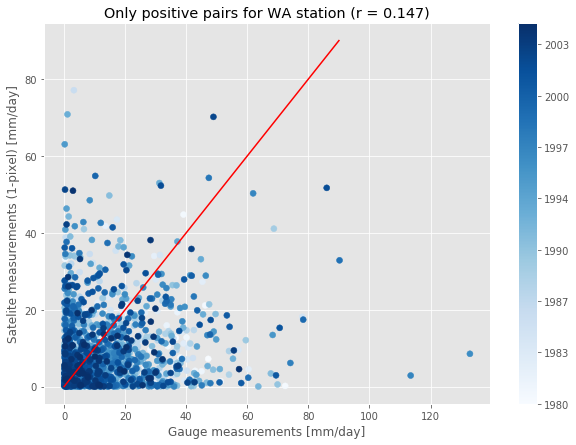

In [61]:
WAtrainPOS = WAtrain[(WAtrain['g[mm]'] > 0.0) & (WAtrain['sat[mm]'] > 0.0)]

rho = WAtrainPOS['g[mm]'].corr(WAtrainPOS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(WAtrainPOS['g[mm]'], WAtrainPOS['sat[mm]'], c=range(len(WAtrainPOS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = WAtrainPOS.index.year[np.arange(0, len(WAtrainPOS), 250)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive pairs for WA station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge ONLY POSITIVE PAIRS measurements for WA station.png');

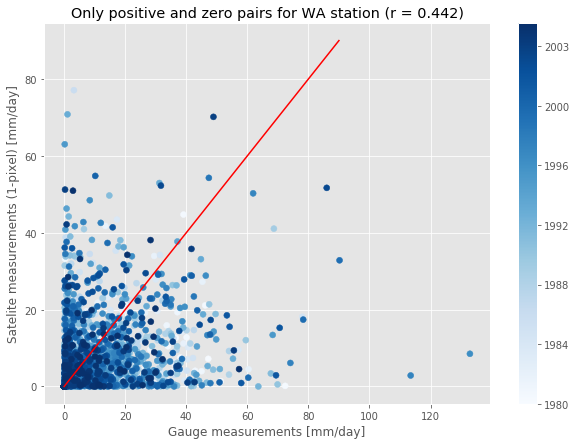

In [62]:
WAtrainPOSandZEROS = WAtrain[((WAtrain['g[mm]'] > 0.0) & (WAtrain['sat[mm]'] > 0.0))  |  ((WAtrain['g[mm]'] == 0.0) & (WAtrain['sat[mm]'] == 0.0))]

rho = WAtrainPOSandZEROS['g[mm]'].corr(WAtrainPOSandZEROS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(WAtrainPOSandZEROS['g[mm]'], WAtrainPOSandZEROS['sat[mm]'], c=range(len(WAtrainPOSandZEROS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = WAtrainPOSandZEROS.index.year[np.arange(0, len(WAtrainPOSandZEROS), 1000)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive and zero pairs for WA station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge ONLY POSITIVE AND ZERO PAIRS measurements for WA station.png');

### Let's plot again the results now deleting the clear outliers (absolute dif >= 20 mm)

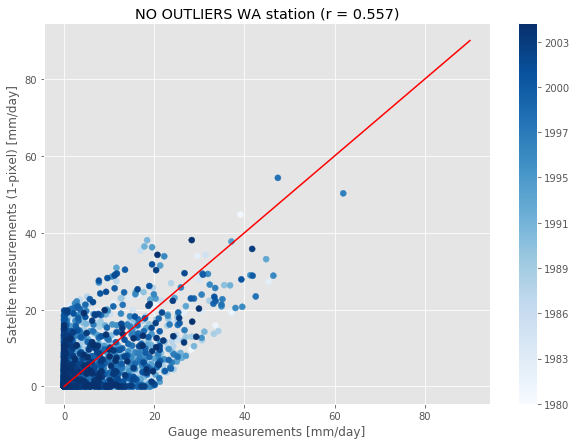

In [63]:
WAtrainPOSandZEROS = WAtrain[np.absolute(WAtrain['g[mm]'] - WAtrain['sat[mm]']) < 20.0]  # delete clear outliers

rho = WAtrainPOSandZEROS['g[mm]'].corr(WAtrainPOSandZEROS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(WAtrainPOSandZEROS['g[mm]'], WAtrainPOSandZEROS['sat[mm]'], c=range(len(WAtrainPOSandZEROS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = WAtrainPOSandZEROS.index.year[np.arange(0, len(WAtrainPOSandZEROS), 1000)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'NO OUTLIERS WA station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge NO OUTLIERS measurements for WA station.png');

### 3-day resolution

In [66]:
WA_3d = pd.DataFrame()

WA_3d['g[mm]'] = WAtrain['g[mm]'].resample(rule = '3d').sum()
WA_3d['sat[mm]'] = WAtrain['sat[mm]'].resample(rule = '3d').sum()

# WA_3d

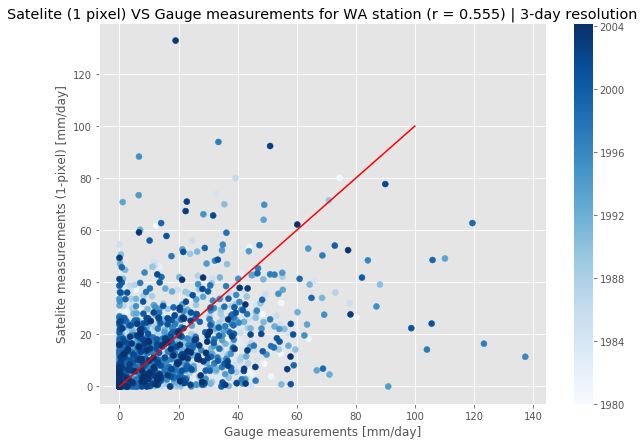

In [72]:
# correlation estimation

rho = WA_3d['g[mm]'].corr(WA_3d['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(WA_3d['g[mm]'], WA_3d['sat[mm]'], c=range(len(WA_3d.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = WA_3d.index.year[np.arange(0, len(WA_3d), 500)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (1 pixel) VS Gauge measurements for WA station (r = {rho:.3f}) | 3-day resolution')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge measurements for WA station (3-day resolution).png');

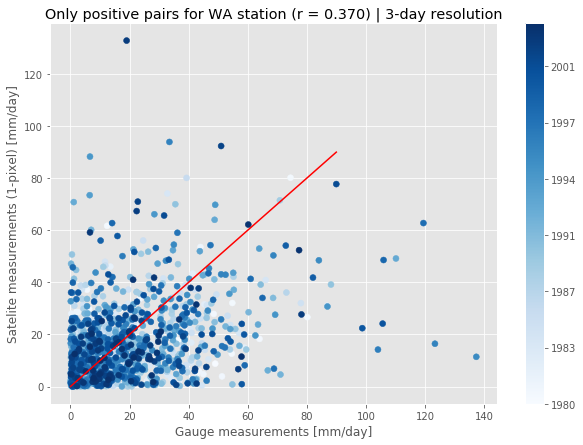

In [76]:
WA_3dPOS = WA_3d[(WA_3d['g[mm]'] > 0.0) & (WA_3d['sat[mm]'] > 0.0)]

rho = WA_3dPOS['g[mm]'].corr(WA_3dPOS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(WA_3dPOS['g[mm]'], WA_3dPOS['sat[mm]'], c=range(len(WA_3dPOS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = WA_3dPOS.index.year[np.arange(0, len(WA_3dPOS), 190)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive pairs for WA station (r = {rho:.3f}) | 3-day resolution')

plt.savefig('DataFigures/ONLY POSITIVE PAIRS measurements for WA station (3-day resolution).png');

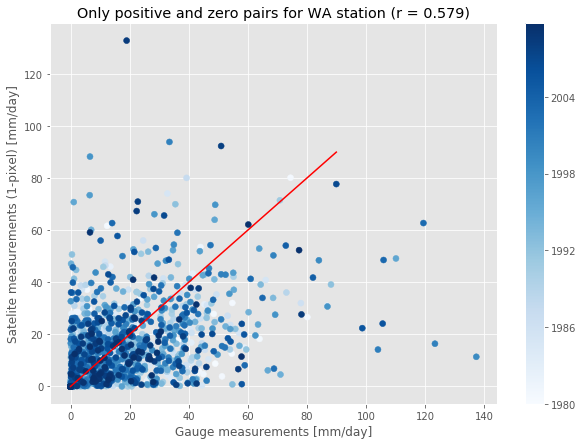

In [83]:
WA_3dPOSandZEROS = WA_3d[((WA_3d['g[mm]'] > 0.0) & (WA_3d['sat[mm]'] > 0.0))  |  ((WA_3d['g[mm]'] == 0.0) & (WA_3d['sat[mm]'] == 0.0))]

rho = WA_3dPOSandZEROS['g[mm]'].corr(WA_3dPOSandZEROS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(WA_3dPOSandZEROS['g[mm]'], WA_3dPOSandZEROS['sat[mm]'], c=range(len(WA_3dPOSandZEROS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = WA_3dPOSandZEROS.index.year[np.arange(0, len(WA_3dPOSandZEROS), 600)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive and zero pairs for WA station (r = {rho:.3f})')

plt.savefig('DataFigures/ONLY POSITIVE AND ZERO PAIRS measurements for WA station (3-day resolution).png');

# 10. ZUARUNGU

In [64]:
ZUARUNGUtrain = ZUARUNGU.merge(ZUARUNGUsat1, how='left', left_on=ZUARUNGU.index, right_on=ZUARUNGUsat1.index)
ZUARUNGUtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
ZUARUNGUtrain.set_index('Date', inplace=True)

ZUARUNGUtrain = ZUARUNGUtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

ZUARUNGUtrain.index = pd.to_datetime(ZUARUNGUtrain.index, errors='coerce')

ZUARUNGUtrain.to_csv("OrganisedData\TrainingData\ZUARUNGUtrain.csv")

# ZUARUNGUtrain

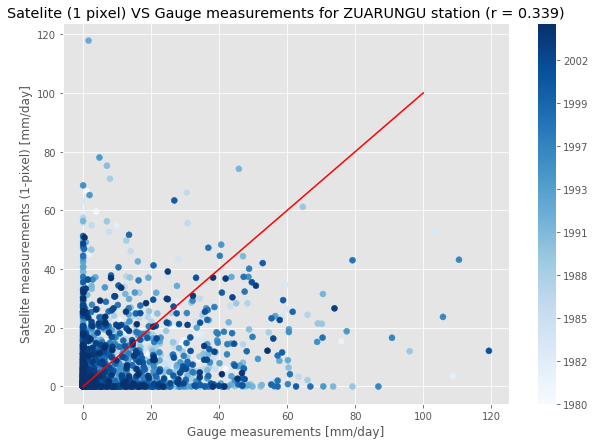

In [65]:
rho = ZUARUNGUtrain['g[mm]'].corr(ZUARUNGUtrain['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(ZUARUNGUtrain['g[mm]'], ZUARUNGUtrain['sat[mm]'], c=range(len(ZUARUNGUtrain.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = ZUARUNGUtrain.index.year[np.arange(0, len(ZUARUNGUtrain), 1000)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (1 pixel) VS Gauge measurements for ZUARUNGU station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge measurements for ZUARUNGU station.png');

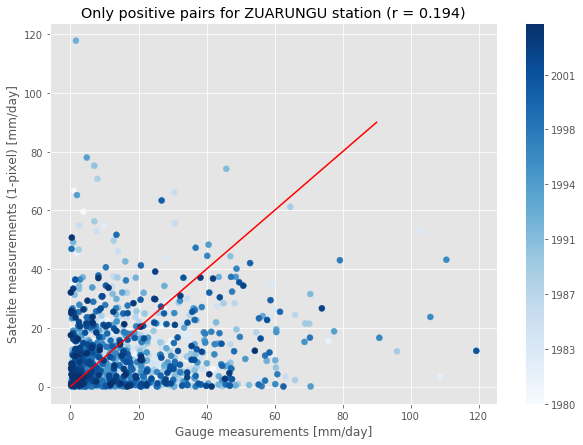

In [66]:
ZUARUNGUtrainPOS = ZUARUNGUtrain[(ZUARUNGUtrain['g[mm]'] > 0.0) & (ZUARUNGUtrain['sat[mm]'] > 0.0)]

rho = ZUARUNGUtrainPOS['g[mm]'].corr(ZUARUNGUtrainPOS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(ZUARUNGUtrainPOS['g[mm]'], ZUARUNGUtrainPOS['sat[mm]'], c=range(len(ZUARUNGUtrainPOS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = ZUARUNGUtrainPOS.index.year[np.arange(0, len(ZUARUNGUtrainPOS), 200)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive pairs for ZUARUNGU station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge ONLY POSITIVE PAIRS measurements for ZUARUNGU station.png');

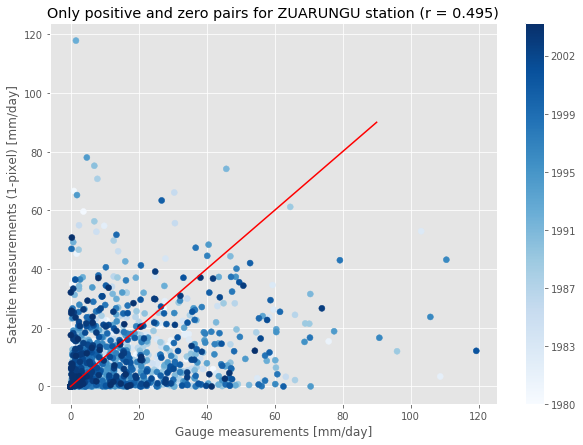

In [67]:
ZUARUNGUtrainPOSandZEROS = ZUARUNGUtrain[((ZUARUNGUtrain['g[mm]'] > 0.0) & (ZUARUNGUtrain['sat[mm]'] > 0.0))  |  ((ZUARUNGUtrain['g[mm]'] == 0.0) & (ZUARUNGUtrain['sat[mm]'] == 0.0))]

rho = ZUARUNGUtrainPOSandZEROS['g[mm]'].corr(ZUARUNGUtrainPOSandZEROS['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.scatter(ZUARUNGUtrainPOSandZEROS['g[mm]'], ZUARUNGUtrainPOSandZEROS['sat[mm]'], c=range(len(ZUARUNGUtrainPOSandZEROS.index)), cmap="Blues")
plt.colorbar()
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

# set the date ticks
clb = plt.gci().colorbar # get the colorbar artist
new_ticks = ZUARUNGUtrainPOSandZEROS.index.year[np.arange(0, len(ZUARUNGUtrainPOSandZEROS), 1000)]
clb.ax.yaxis.set_ticklabels(new_ticks)



plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Only positive and zero pairs for ZUARUNGU station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge ONLY POSITIVE AND ZERO PAIRS measurements for ZUARUNGU station.png');

# 11. ANIABISI

In [76]:
ANIABISItrain = ANIABISI.merge(ANIABISIsat1, how='left', left_on=ANIABISI.index, right_on=ANIABISIsat1.index)
ANIABISItrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
ANIABISItrain.set_index('Date', inplace=True)

ANIABISItrain = ANIABISItrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

ANIABISItrain.to_csv("OrganisedData\TrainingData\ANIABISItrain.csv")

ANIABISItrain

g[mm]  sat[mm]
Date                      
2014-06-04   0.00     1.35
2014-06-05   1.25     2.53
2014-06-06   9.05     9.76
2014-06-07   0.00     0.00
2014-06-08   0.00     0.00
...           ...      ...
2015-12-27   0.00     0.00
2015-12-28   0.00     0.00
2015-12-29   0.00     0.00
2015-12-30   0.00     0.00
2015-12-31   0.00     0.00

[576 rows x 2 columns]

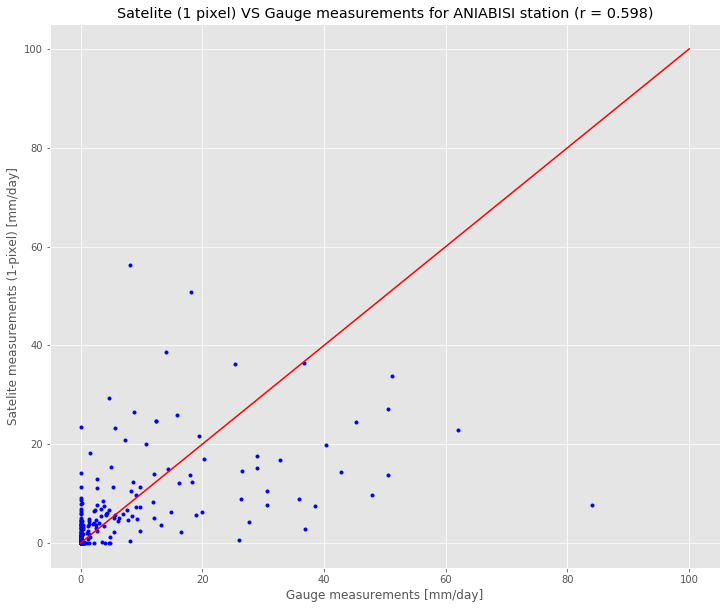

In [77]:
rho = ANIABISItrain['g[mm]'].corr(ANIABISItrain['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.plot(ANIABISItrain['g[mm]'], ANIABISItrain['sat[mm]'], 'b.')
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (1 pixel) VS Gauge measurements for ANIABISI station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge measurements for ANIABISI station.png');

# 12. POUDRI

In [78]:
POUDRItrain = POUDRI.merge(POUDRIsat1, how='left', left_on=POUDRI.index, right_on=POUDRIsat1.index)
POUDRItrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
POUDRItrain.set_index('Date', inplace=True)

POUDRItrain = POUDRItrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

POUDRItrain.to_csv("OrganisedData\TrainingData\POUDRItrain.csv")

POUDRItrain

g[mm]  sat[mm]
Date                      
2013-06-25   0.90     3.58
2013-06-26   0.00     0.50
2013-06-27  31.55    15.47
2013-06-28   0.00     4.24
2013-06-29  12.45    16.73
...           ...      ...
2015-12-27   0.00     0.00
2015-12-28   0.05     0.00
2015-12-29   0.00     0.00
2015-12-30   0.00     0.00
2015-12-31   0.00     0.00

[920 rows x 2 columns]

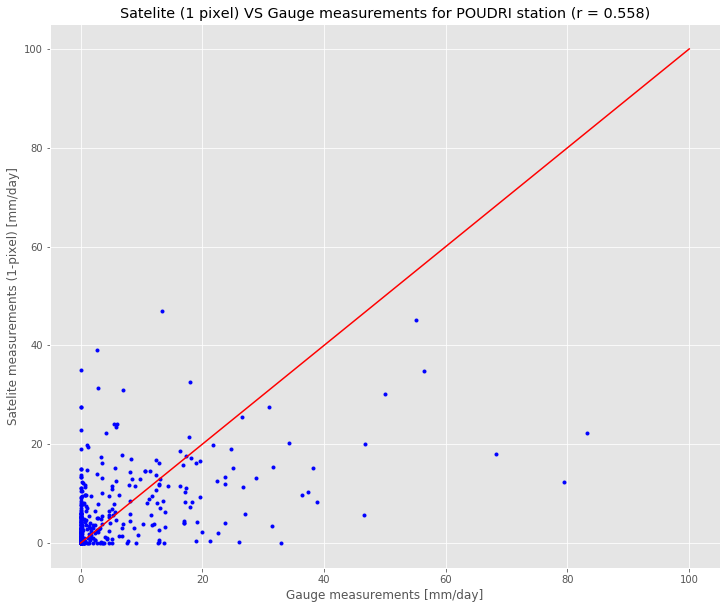

In [79]:
rho = POUDRItrain['g[mm]'].corr(POUDRItrain['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.plot(POUDRItrain['g[mm]'], POUDRItrain['sat[mm]'], 'b.')
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (1 pixel) VS Gauge measurements for POUDRI station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge measurements for POUDRI station.png');

# 13. LARE

In [81]:
LAREtrain = LARE.merge(LAREsat1, how='left', left_on=LARE.index, right_on=LAREsat1.index)
LAREtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
LAREtrain.set_index('Date', inplace=True)

LAREtrain = LAREtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

LAREtrain.to_csv("OrganisedData\TrainingData\LAREtrain.csv")

LAREtrain

g[mm]  sat[mm]
Date                      
2013-09-26    0.0     0.00
2013-09-27    0.2    10.69
2013-09-28    1.6     8.57
2013-09-29    0.0     1.46
2013-09-30   33.4    10.92
...           ...      ...
2015-12-27    0.0     0.00
2015-12-28    0.0     0.00
2015-12-29    0.0     0.00
2015-12-30    0.0     0.00
2015-12-31    0.0     0.00

[827 rows x 2 columns]

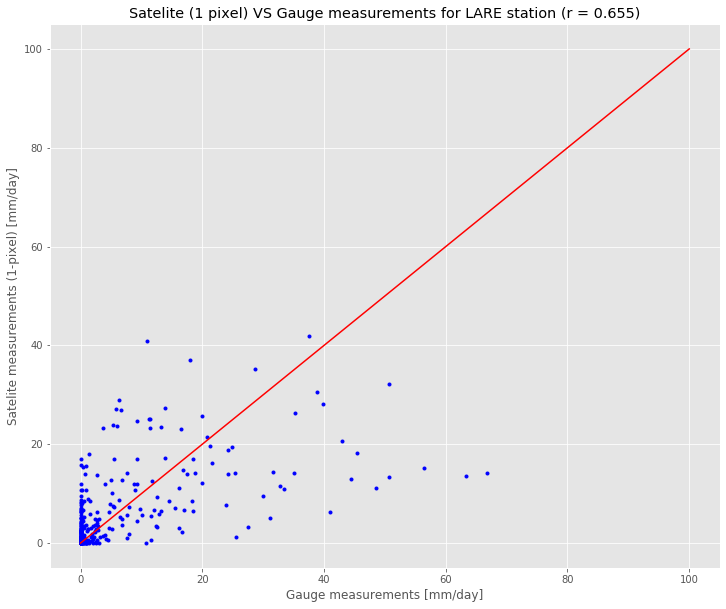

In [82]:
rho = LAREtrain['g[mm]'].corr(LAREtrain['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.plot(LAREtrain['g[mm]'], LAREtrain['sat[mm]'], 'b.')
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (1 pixel) VS Gauge measurements for LARE station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge measurements for LARE station.png');

# 14. YABOGANE

In [83]:
YABOGANEtrain = YABOGANE.merge(YABOGANEsat1, how='left', left_on=YABOGANE.index, right_on=YABOGANEsat1.index)
YABOGANEtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
YABOGANEtrain.set_index('Date', inplace=True)

YABOGANEtrain = YABOGANEtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

YABOGANEtrain.to_csv("OrganisedData\TrainingData\YABOGANEtrain.csv")

YABOGANEtrain

g[mm]  sat[mm]
Date                      
2012-10-01   0.00     0.10
2012-10-02   0.45     3.32
2012-10-03   0.00     1.05
2012-10-04   2.80     3.50
2012-10-05   0.00     1.58
...           ...      ...
2015-12-27   0.00     0.00
2015-12-28   0.00     0.00
2015-12-29   0.00     0.00
2015-12-30   0.00     0.00
2015-12-31   0.00     0.00

[1187 rows x 2 columns]

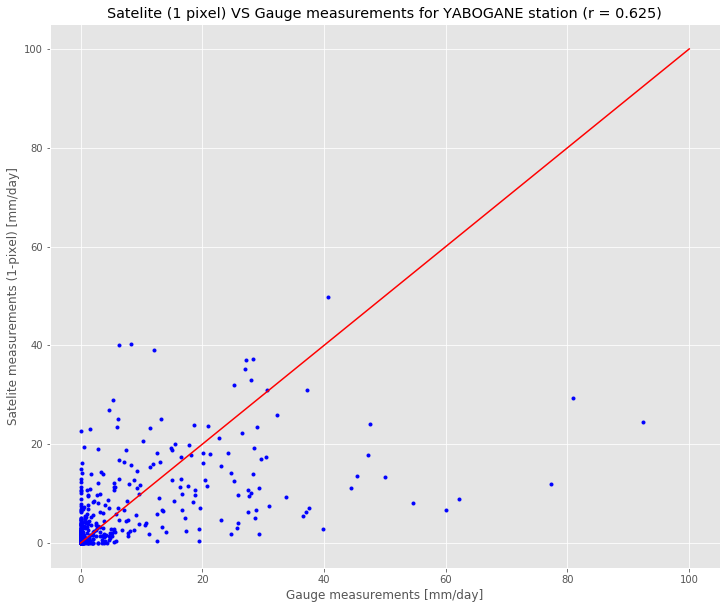

In [84]:
rho = YABOGANEtrain['g[mm]'].corr(YABOGANEtrain['sat[mm]'])

plt.figure(figsize=(10, 7))

plt.plot(YABOGANEtrain['g[mm]'], YABOGANEtrain['sat[mm]'], 'b.')
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

plt.ylabel('Satelite measurements (1-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (1 pixel) VS Gauge measurements for YABOGANE station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (1 pixel) VS Gauge measurements for YABOGANE station.png');

# Define the correlations for different months

In [126]:
months = np.array(["January",
                  "February",
                  "March",
                  "April",
                  "May",
                  "June",
                  "July",
                  "August",
                  "September",
                  "October",
                  "November",
                  "December"
                  ])

In [128]:
rhoTILLABERI = np.zeros(12)

print('Monthly TILLABERI station correlations')
print('---' * 15)

for i in range(len(rhoTILLABERI)):
    
    TILLABERItrainMonth = TILLABERItrain[TILLABERItrain.index.month.isin([i])]
    rhoTILLABERI[i] = TILLABERItrainMonth['g[mm]'].corr(TILLABERItrainMonth['sat[mm]'])

    print(f'For {months[i]} rho is {rhoTILLABERI[i]:.3f}.')

Monthly TILLABERI station correlations
---------------------------------------------
For January rho is nan.
For February rho is nan.
For March rho is nan.
For April rho is nan.
For May rho is 0.156.
For June rho is 0.404.
For July rho is 0.394.
For August rho is 0.357.
For September rho is 0.353.
For October rho is 0.398.
For November rho is 0.401.
For December rho is 0.019.


In [129]:
rhoTOBRE = np.zeros(12)

print('Monthly TOBRE station correlations')
print('---' * 15)

for i in range(len(rhoTOBRE)):
    
    TOBREtrainMonth = TOBREtrain[TOBREtrain.index.month.isin([i])]
    rhoTOBRE[i] = TOBREtrainMonth['g[mm]'].corr(TOBREtrainMonth['sat[mm]'])

    print(f'For {months[i]} rho is {rhoTOBRE[i]:.3f}.')

Monthly TOBRE station correlations
---------------------------------------------
For January rho is nan.
For February rho is 0.790.
For March rho is 0.314.
For April rho is 0.122.
For May rho is 0.215.
For June rho is 0.290.
For July rho is 0.241.
For August rho is 0.113.
For September rho is 0.048.
For October rho is 0.216.
For November rho is 0.289.
For December rho is 0.231.


In [130]:
rhoTARA = np.zeros(12)

print('Monthly TARA station correlations')
print('---' * 15)

for i in range(len(rhoTARA)):
    
    TARAtrainMonth = TARAtrain[TARAtrain.index.month.isin([i])]
    rhoTARA[i] = TARAtrainMonth['g[mm]'].corr(TARAtrainMonth['sat[mm]'])

    print(f'For {months[i]} rho is {rhoTARA[i]:.3f}.')

Monthly TARA station correlations
---------------------------------------------
For January rho is nan.
For February rho is nan.
For March rho is nan.
For April rho is nan.
For May rho is nan.
For June rho is 0.378.
For July rho is 0.536.
For August rho is 0.684.
For September rho is 0.577.
For October rho is 0.604.
For November rho is 0.741.
For December rho is nan.


In [131]:
rhoAGOUFOU = np.zeros(12)

print('Monthly AGOUFOU station correlations')
print('---' * 15)

for i in range(len(rhoAGOUFOU)):
    
    AGOUFOUtrainMonth = AGOUFOUtrain[AGOUFOUtrain.index.month.isin([i])]
    rhoAGOUFOU[i] = AGOUFOUtrainMonth['g[mm]'].corr(AGOUFOUtrainMonth['sat[mm]'])

    print(f'For {months[i]} rho is {rhoAGOUFOU[i]:.3f}.')

Monthly AGOUFOU station correlations
---------------------------------------------
For January rho is nan.
For February rho is nan.
For March rho is nan.
For April rho is nan.
For May rho is 0.612.
For June rho is 0.800.
For July rho is 0.562.
For August rho is 0.580.
For September rho is 0.612.
For October rho is 0.551.
For November rho is 0.498.
For December rho is nan.


### Plot of monthly correlations of the AMMA dataset

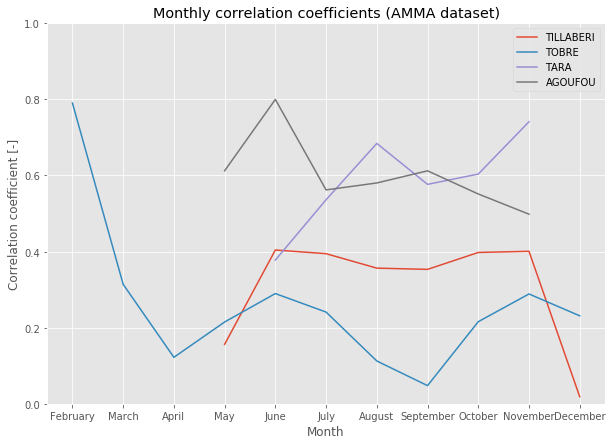

In [136]:
plt.figure(figsize=(10, 7))

plt.plot(months, rhoTILLABERI, label='TILLABERI')
plt.plot(months, rhoTOBRE, label='TOBRE')
plt.plot(months, rhoTARA, label='TARA')
plt.plot(months, rhoAGOUFOU, label='AGOUFOU')

plt.legend()

plt.ylabel('Correlation coefficient [-]')
plt.xlabel('Month')
plt.ylim(0, 1)

plt.title(f'Monthly correlation coefficients (AMMA dataset)')

plt.savefig('DataFigures/Monthly correlation coefficients (AMMA dataset).png');

In [137]:
rhoLAWRA = np.zeros(12)

print('Monthly LAWRA station correlations')
print('---' * 15)

for i in range(len(rhoLAWRA)):
    
    LAWRAtrainMonth = LAWRAtrain[LAWRAtrain.index.month.isin([i])]
    rhoLAWRA[i] = LAWRAtrainMonth['g[mm]'].corr(LAWRAtrainMonth['sat[mm]'])

    print(f'For {months[i]} rho is {rhoLAWRA[i]:.3f}.')

Monthly LAWRA station correlations
---------------------------------------------
For January rho is nan.
For February rho is 0.021.
For March rho is 0.463.
For April rho is 0.174.
For May rho is 0.211.
For June rho is 0.350.
For July rho is 0.294.
For August rho is 0.184.
For September rho is 0.437.
For October rho is 0.389.
For November rho is 0.314.
For December rho is 0.167.


In [138]:
rhoNAVRONGO = np.zeros(12)

print('Monthly NAVRONGO station correlations')
print('---' * 15)

for i in range(len(rhoNAVRONGO)):
    
    NAVRONGOtrainMonth = NAVRONGOtrain[NAVRONGOtrain.index.month.isin([i])]
    rhoNAVRONGO[i] = NAVRONGOtrainMonth['g[mm]'].corr(NAVRONGOtrainMonth['sat[mm]'])

    print(f'For {months[i]} rho is {rhoNAVRONGO[i]:.3f}.')

Monthly NAVRONGO station correlations
---------------------------------------------
For January rho is nan.
For February rho is 0.078.
For March rho is 0.179.
For April rho is 0.279.
For May rho is 0.331.
For June rho is 0.190.
For July rho is 0.206.
For August rho is 0.101.
For September rho is 0.252.
For October rho is 0.210.
For November rho is 0.267.
For December rho is 0.131.


In [139]:
rhoOUAHIGOUYA = np.zeros(12)

print('Monthly OUAHIGOUYA station correlations')
print('---' * 15)

for i in range(len(rhoOUAHIGOUYA)):
    
    OUAHIGOUYAtrainMonth = OUAHIGOUYAtrain[OUAHIGOUYAtrain.index.month.isin([i])]
    rhoOUAHIGOUYA[i] = OUAHIGOUYAtrainMonth['g[mm]'].corr(OUAHIGOUYAtrainMonth['sat[mm]'])

    print(f'For {months[i]} rho is {rhoOUAHIGOUYA[i]:.3f}.')

Monthly OUAHIGOUYA station correlations
---------------------------------------------
For January rho is nan.
For February rho is -0.002.
For March rho is nan.
For April rho is 0.283.
For May rho is 0.543.
For June rho is 0.498.
For July rho is 0.556.
For August rho is 0.466.
For September rho is 0.497.
For October rho is 0.632.
For November rho is 0.755.
For December rho is 0.921.


In [140]:
rhoTAMALE = np.zeros(12)

print('Monthly TAMALE station correlations')
print('---' * 15)

for i in range(len(rhoTAMALE)):
    
    TAMALEtrainMonth = TAMALEtrain[TAMALEtrain.index.month.isin([i])]
    rhoTAMALE[i] = TAMALEtrainMonth['g[mm]'].corr(TAMALEtrainMonth['sat[mm]'])

    print(f'For {months[i]} rho is {rhoTAMALE[i]:.3f}.')

Monthly TAMALE station correlations
---------------------------------------------
For January rho is nan.
For February rho is 0.198.
For March rho is 0.113.
For April rho is 0.354.
For May rho is 0.193.
For June rho is 0.229.
For July rho is 0.299.
For August rho is 0.204.
For September rho is 0.265.
For October rho is 0.264.
For November rho is 0.295.
For December rho is 0.432.


In [141]:
rhoWA = np.zeros(12)

print('Monthly WA station correlations')
print('---' * 15)

for i in range(len(rhoWA)):
    
    WAtrainMonth = WAtrain[WAtrain.index.month.isin([i])]
    rhoWA[i] = WAtrainMonth['g[mm]'].corr(WAtrainMonth['sat[mm]'])

    print(f'For {months[i]} rho is {rhoWA[i]:.3f}.')

Monthly WA station correlations
---------------------------------------------
For January rho is nan.
For February rho is 0.268.
For March rho is 0.104.
For April rho is 0.411.
For May rho is 0.215.
For June rho is 0.301.
For July rho is 0.177.
For August rho is 0.261.
For September rho is 0.243.
For October rho is 0.176.
For November rho is 0.233.
For December rho is 0.121.


In [142]:
rhoZUARUNGU = np.zeros(12)

print('Monthly ZUARUNGU station correlations')
print('---' * 15)

for i in range(len(rhoZUARUNGU)):
    
    ZUARUNGUtrainMonth = ZUARUNGUtrain[ZUARUNGUtrain.index.month.isin([i])]
    rhoZUARUNGU[i] = ZUARUNGUtrainMonth['g[mm]'].corr(ZUARUNGUtrainMonth['sat[mm]'])

    print(f'For {months[i]} rho is {rhoZUARUNGU[i]:.3f}.')

Monthly ZUARUNGU station correlations
---------------------------------------------
For January rho is nan.
For February rho is -0.002.
For March rho is 0.028.
For April rho is 0.450.
For May rho is 0.343.
For June rho is 0.174.
For July rho is 0.281.
For August rho is 0.130.
For September rho is 0.308.
For October rho is 0.224.
For November rho is 0.305.
For December rho is 0.169.


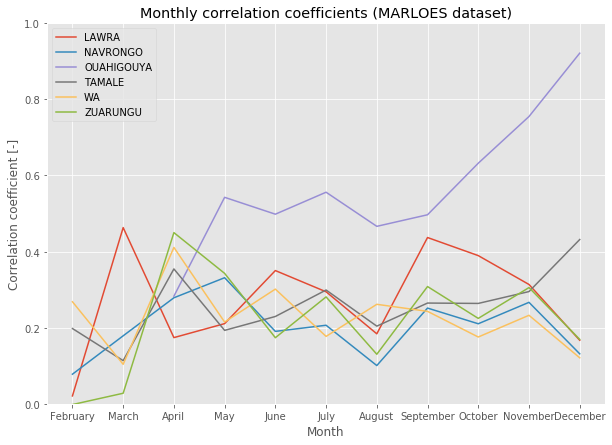

In [143]:
plt.figure(figsize=(10, 7))

plt.plot(months, rhoLAWRA, label='LAWRA')
plt.plot(months, rhoNAVRONGO, label='NAVRONGO')
plt.plot(months, rhoOUAHIGOUYA, label='OUAHIGOUYA')
plt.plot(months, rhoTAMALE, label='TAMALE')
plt.plot(months, rhoWA, label='WA')
plt.plot(months, rhoZUARUNGU, label='ZUARUNGU')

plt.legend()

plt.ylabel('Correlation coefficient [-]')
plt.xlabel('Month')
plt.ylim(0, 1)

plt.title(f'Monthly correlation coefficients (MARLOES dataset)')

plt.savefig('DataFigures/Monthly correlation coefficients (MARLOES dataset).png');

# Spatial correlation

In [32]:
locations = pd.read_csv('Data\stations.txt', sep=' ', index_col=0)

locations.head(20)

database  station_latitude(dec.degree)  \
station_name                                             
TILLABERI     AMMA-CATCH                     14.204300   
TOBRE         AMMA-CATCH                     10.199100   
TARA          AMMA-CATCH                     15.251400   
AGOUFOU       AMMA-CATCH                     15.360000   
LAWRA            MARLOES                     10.866670   
NAVRONGO         MARLOES                     10.530000   
OUAHIGOUYA       MARLOES                     13.520000   
TAMALE           MARLOES                      9.330000   
WA               MARLOES                     10.030000   
ZUARUNGU         MARLOES                     10.783300   
ANIABISI          WASCAL                     10.847251   
POUDRI            WASCAL                     10.913934   
LARE              WASCAL                     11.192883   
YABOGANE          WASCAL                     11.261641   

              station_longitude(dec.degree)  station_altitude(m)  
station_name                                                      
TILLABERI                          1.454500                212.0  
TOBRE                              2.133500                371.0  
TARA                              -1.585500                335.0  
AGOUFOU                           -1.470000                340.0  
LAWRA                             -1.483330                305.0  
NAVRONGO                          -1.050000                201.3  
OUAHIGOUYA                        -2.390000                365.0  
TAMALE                            -0.510000                183.3  
WA                                -2.090000                322.7  
ZUARUNGU                          -0.800000                235.0  
ANIABISI                          -0.910629                220.0  
POUDRI                             1.111897                190.0  
LARE                              -3.095351                320.0  
YABOGANE                          -2.968168                305.0

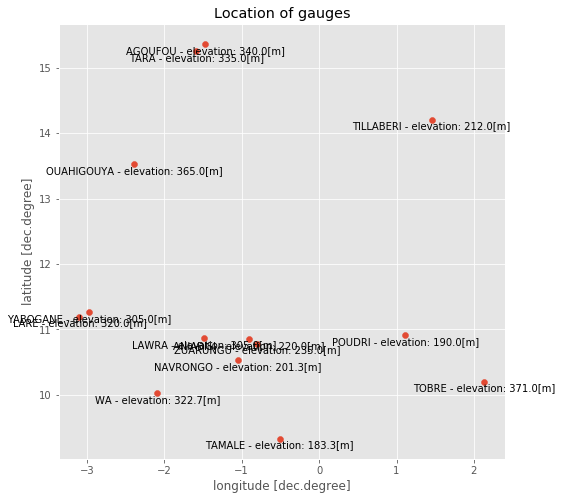

In [107]:
plt.figure(figsize=(8, 8))

plt.scatter(locations['station_longitude(dec.degree)'], locations['station_latitude(dec.degree)'])

for i in range(len(locations)):
    plt.text(locations['station_longitude(dec.degree)'][i], locations['station_latitude(dec.degree)'][i]  - 0.1, locations.index[i] + ' - elevation: ' + str(locations['station_altitude(m)'][i]) + '[m]', horizontalalignment='center', verticalalignment='center')

plt.xlabel('longitude [dec.degree]')
plt.ylabel('latitude [dec.degree]')
plt.title('Location of gauges')

plt.savefig('DataFigures/Location of gauges.png');

# North cluster (Tara, Agoufou, Ouahigouya, Tillaberi)
### Gauge spatial correlation

In [86]:
r = []
dist = []

In [87]:
sp = TARA.merge(AGOUFOU, how='left', left_on=TARA.index, right_on=AGOUFOU.index)
sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
sp.set_index('Date', inplace=True)

sp.index = pd.to_datetime(sp.index, errors='coerce')

rho = sp['R1[mm]'].corr(sp['R2[mm]'])
r.append(rho)

d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][2] - locations['station_longitude(dec.degree)'][3])**2 + np.abs(locations['station_latitude(dec.degree)'][2] - locations['station_latitude(dec.degree)'][3])**2)
d = d * 111.32  # dec. degrees to kms
dist.append(d)

dist


[17.64841945986953]

In [88]:
sp = TARA.merge(OUAHIGOUYA, how='left', left_on=TARA.index, right_on=OUAHIGOUYA.index)
sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
sp.set_index('Date', inplace=True)

sp.index = pd.to_datetime(sp.index, errors='coerce')

sp = sp.dropna(axis=0, how='any')  # remove Nan

rho = sp['R1[mm]'].corr(sp['R2[mm]'])
r.append(rho)

d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][2] - locations['station_longitude(dec.degree)'][6])**2 + np.abs(locations['station_latitude(dec.degree)'][2] - locations['station_latitude(dec.degree)'][6])**2)
d = d * 111.32  # dec. degrees to kms
dist.append(d)

r


[0.529144632725408, 0.22605027103003766]

In [89]:
sp = TARA.merge(TILLABERI, how='left', left_on=TARA.index, right_on=TILLABERI.index)
sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
sp.set_index('Date', inplace=True)

sp.index = pd.to_datetime(sp.index, errors='coerce')

sp = sp.dropna(axis=0, how='any')  # remove Nan

rho = sp['R1[mm]'].corr(sp['R2[mm]'])
r.append(rho)

d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][2] - locations['station_longitude(dec.degree)'][0])**2 + np.abs(locations['station_latitude(dec.degree)'][2] - locations['station_latitude(dec.degree)'][0])**2)
d = d * 111.32  # dec. degrees to kms
dist.append(d)

r

[0.529144632725408, 0.22605027103003766, 0.09124773938492522]

In [90]:
sp = AGOUFOU.merge(OUAHIGOUYA, how='left', left_on=AGOUFOU.index, right_on=OUAHIGOUYA.index)
sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
sp.set_index('Date', inplace=True)

sp.index = pd.to_datetime(sp.index, errors='coerce')

sp = sp.dropna(axis=0, how='any')  # remove Nan

rho = sp['R1[mm]'].corr(sp['R2[mm]'])
r.append(rho)

d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][3] - locations['station_longitude(dec.degree)'][6])**2 + np.abs(locations['station_latitude(dec.degree)'][3] - locations['station_latitude(dec.degree)'][6])**2)
d = d * 111.32  # dec. degrees to kms
dist.append(d)

r


[0.529144632725408,
 0.22605027103003766,
 0.09124773938492522,
 0.18931690178763433]

In [91]:
sp = AGOUFOU.merge(TILLABERI, how='left', left_on=AGOUFOU.index, right_on=TILLABERI.index)
sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
sp.set_index('Date', inplace=True)

sp.index = pd.to_datetime(sp.index, errors='coerce')

sp = sp.dropna(axis=0, how='any')  # remove Nan

rho = sp['R1[mm]'].corr(sp['R2[mm]'])
r.append(rho)

d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][0] - locations['station_longitude(dec.degree)'][3])**2 + np.abs(locations['station_latitude(dec.degree)'][0] - locations['station_latitude(dec.degree)'][3])**2)
d = d * 111.32  # dec. degrees to kms
dist.append(d)

r


[0.529144632725408,
 0.22605027103003766,
 0.09124773938492522,
 0.18931690178763433,
 0.12157385806003845]

In [92]:
sp = OUAHIGOUYA.merge(TILLABERI, how='left', left_on=OUAHIGOUYA.index, right_on=TILLABERI.index)
sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
sp.set_index('Date', inplace=True)

sp.index = pd.to_datetime(sp.index, errors='coerce')

sp = sp.dropna(axis=0, how='any')  # remove Nan

rho = sp['R1[mm]'].corr(sp['R2[mm]'])
r.append(rho)

d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][0] - locations['station_longitude(dec.degree)'][6])**2 + np.abs(locations['station_latitude(dec.degree)'][0] - locations['station_latitude(dec.degree)'][6])**2)
d = d * 111.32  # dec. degrees to kms
dist.append(d)

print(r, dist)

[0.529144632725408, 0.22605027103003766, 0.09124773938492522, 0.18931690178763433, 0.12157385806003845, 0.11754995596217706] [17.64841945986953, 212.5298574730344, 357.9248472382737, 229.00556027485442, 350.0539263229112, 434.696357680733]


In [93]:
r = [r for _,r in sorted(zip(dist,r))]  # sort based on distances

dist = np.sort(dist)
# dist

r

[0.529144632725408,
 0.22605027103003766,
 0.18931690178763433,
 0.12157385806003845,
 0.09124773938492522,
 0.11754995596217706]

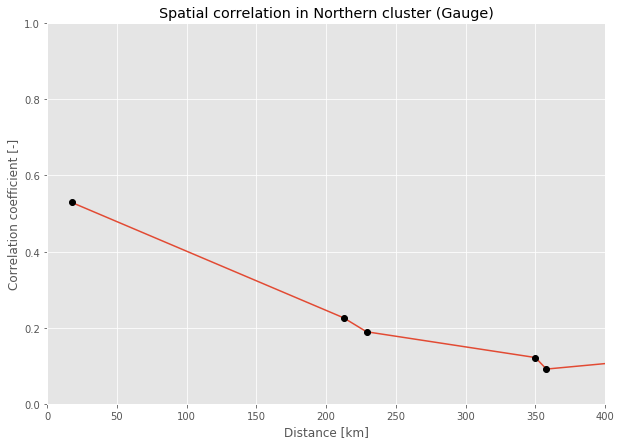

In [97]:
plt.figure(figsize=(10, 7))

plt.plot(dist, r)
plt.plot(dist, r, 'o', color='black')


plt.ylabel('Correlation coefficient [-]')
plt.xlabel('Distance [km]')
plt.ylim(0, 1)
plt.xlim(0, 400)

plt.title(f'Spatial correlation in Northern cluster (Gauge)')

plt.savefig('DataFigures/Spatial correlation in Northern cluster (Gauge).png');

### satellite spatial correlation

In [98]:
r = []
dist = []

In [99]:
sp = TARAsat1.merge(AGOUFOUsat1, how='left', left_on=TARAsat1.index, right_on=AGOUFOUsat1.index)
sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
sp.set_index('Date', inplace=True)

sp.index = pd.to_datetime(sp.index, errors='coerce')

rho = sp['R1[mm]'].corr(sp['R2[mm]'])
r.append(rho)

d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][2] - locations['station_longitude(dec.degree)'][3])**2 + np.abs(locations['station_latitude(dec.degree)'][2] - locations['station_latitude(dec.degree)'][3])**2)
d = d * 111.32  # dec. degrees to kms
dist.append(d)

dist


[17.64841945986953]

In [100]:
sp = TARAsat1.merge(OUAHIGOUYAsat1, how='left', left_on=TARAsat1.index, right_on=OUAHIGOUYAsat1.index)
sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
sp.set_index('Date', inplace=True)

sp.index = pd.to_datetime(sp.index, errors='coerce')

sp = sp.dropna(axis=0, how='any')  # remove Nan

rho = sp['R1[mm]'].corr(sp['R2[mm]'])
r.append(rho)

d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][2] - locations['station_longitude(dec.degree)'][6])**2 + np.abs(locations['station_latitude(dec.degree)'][2] - locations['station_latitude(dec.degree)'][6])**2)
d = d * 111.32  # dec. degrees to kms
dist.append(d)

r


[0.9532021943669834, 0.38365756035058624]

In [101]:
sp = TARAsat1.merge(TILLABERIsat1, how='left', left_on=TARAsat1.index, right_on=TILLABERIsat1.index)
sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
sp.set_index('Date', inplace=True)

sp.index = pd.to_datetime(sp.index, errors='coerce')

sp = sp.dropna(axis=0, how='any')  # remove Nan

rho = sp['R1[mm]'].corr(sp['R2[mm]'])
r.append(rho)

d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][2] - locations['station_longitude(dec.degree)'][0])**2 + np.abs(locations['station_latitude(dec.degree)'][2] - locations['station_latitude(dec.degree)'][0])**2)
d = d * 111.32  # dec. degrees to kms
dist.append(d)

r

[0.9532021943669834, 0.38365756035058624, 0.28166074175773326]

In [102]:
sp = AGOUFOUsat1.merge(OUAHIGOUYAsat1, how='left', left_on=AGOUFOUsat1.index, right_on=OUAHIGOUYAsat1.index)
sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
sp.set_index('Date', inplace=True)

sp.index = pd.to_datetime(sp.index, errors='coerce')

sp = sp.dropna(axis=0, how='any')  # remove Nan

rho = sp['R1[mm]'].corr(sp['R2[mm]'])
r.append(rho)

d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][3] - locations['station_longitude(dec.degree)'][6])**2 + np.abs(locations['station_latitude(dec.degree)'][3] - locations['station_latitude(dec.degree)'][6])**2)
d = d * 111.32  # dec. degrees to kms
dist.append(d)

r


[0.9532021943669834,
 0.38365756035058624,
 0.28166074175773326,
 0.35192412186930244]

In [103]:
sp = AGOUFOUsat1.merge(TILLABERIsat1, how='left', left_on=AGOUFOUsat1.index, right_on=TILLABERIsat1.index)
sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
sp.set_index('Date', inplace=True)

sp.index = pd.to_datetime(sp.index, errors='coerce')

sp = sp.dropna(axis=0, how='any')  # remove Nan

rho = sp['R1[mm]'].corr(sp['R2[mm]'])
r.append(rho)

d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][0] - locations['station_longitude(dec.degree)'][3])**2 + np.abs(locations['station_latitude(dec.degree)'][0] - locations['station_latitude(dec.degree)'][3])**2)
d = d * 111.32  # dec. degrees to kms
dist.append(d)

r


[0.9532021943669834,
 0.38365756035058624,
 0.28166074175773326,
 0.35192412186930244,
 0.2833241452694423]

In [104]:
sp = OUAHIGOUYAsat1.merge(TILLABERIsat1, how='left', left_on=OUAHIGOUYAsat1.index, right_on=TILLABERIsat1.index)
sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
sp.set_index('Date', inplace=True)

sp.index = pd.to_datetime(sp.index, errors='coerce')

sp = sp.dropna(axis=0, how='any')  # remove Nan

rho = sp['R1[mm]'].corr(sp['R2[mm]'])
r.append(rho)

d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][0] - locations['station_longitude(dec.degree)'][6])**2 + np.abs(locations['station_latitude(dec.degree)'][0] - locations['station_latitude(dec.degree)'][6])**2)
d = d * 111.32  # dec. degrees to kms
dist.append(d)

print(r, dist)

[0.9532021943669834, 0.38365756035058624, 0.28166074175773326, 0.35192412186930244, 0.2833241452694423, 0.23187936160562067] [17.64841945986953, 212.5298574730344, 357.9248472382737, 229.00556027485442, 350.0539263229112, 434.696357680733]


In [105]:
r = [r for _,r in sorted(zip(dist,r))]  # sort based on distances

dist = np.sort(dist)
# dist

r

[0.9532021943669834,
 0.38365756035058624,
 0.35192412186930244,
 0.2833241452694423,
 0.28166074175773326,
 0.23187936160562067]

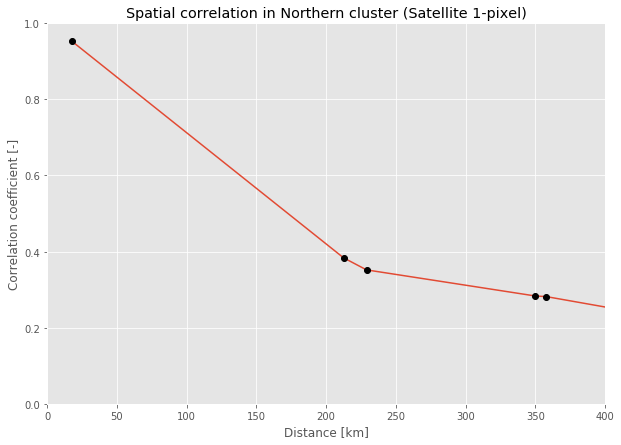

In [106]:
plt.figure(figsize=(10, 7))

plt.plot(dist, r)
plt.plot(dist, r, 'o', color='black')


plt.ylabel('Correlation coefficient [-]')
plt.xlabel('Distance [km]')
plt.ylim(0, 1)
plt.xlim(0, 400)

plt.title(f'Spatial correlation in Northern cluster (Satellite 1-pixel)')

plt.savefig('DataFigures/Spatial correlation in Northern cluster (Satellite 1-pixel).png');

# Mid cluster (Navrongo, Lawra, Zuarungu, Wa)
### Gauge spatial correlation

In [141]:
r = []
dist = []

In [142]:
sp = NAVRONGO.merge(LAWRA, how='left', left_on=NAVRONGO.index, right_on=LAWRA.index)
sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
sp.set_index('Date', inplace=True)

sp.index = pd.to_datetime(sp.index, errors='coerce')

sp = sp.dropna(axis=0, how='any')  # remove Nan

rho = sp['R1[mm]'].corr(sp['R2[mm]'])
r.append(rho)

d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][5] - locations['station_longitude(dec.degree)'][4])**2 + np.abs(locations['station_latitude(dec.degree)'][5] - locations['station_latitude(dec.degree)'][4])**2)
d = d * 111.32  # dec. degrees to kms
dist.append(d)

r


[0.2754898042705225]

In [143]:
ANIABISI = ANIABISI.dropna(axis=0, how='any')  # remove Nan
# sp = NAVRONGO.merge(ANIABISI, how='left', left_on=NAVRONGO.index, right_on=ANIABISI.index)
# sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
# sp.set_index('Date', inplace=True)

# sp.index = pd.to_datetime(sp.index, errors='coerce')

# sp = sp.dropna(axis=0, how='any')  # remove Nan

# rho = sp['R1[mm]'].corr(sp['R2[mm]'])
# r.append(rho)

# d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][5] - locations['station_longitude(dec.degree)'][10])**2 + np.abs(locations['station_latitude(dec.degree)'][5] - locations['station_latitude(dec.degree)'][10])**2)
# d = d * 111.32  # dec. degrees to kms
# dist.append(d)

# r


In [144]:
sp = NAVRONGO.merge(ZUARUNGU, how='left', left_on=NAVRONGO.index, right_on=ZUARUNGU.index)
sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
sp.set_index('Date', inplace=True)

sp.index = pd.to_datetime(sp.index, errors='coerce')

sp = sp.dropna(axis=0, how='any')  # remove Nan

rho = sp['R1[mm]'].corr(sp['R2[mm]'])
r.append(rho)

d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][5] - locations['station_longitude(dec.degree)'][9])**2 + np.abs(locations['station_latitude(dec.degree)'][5] - locations['station_latitude(dec.degree)'][9])**2)
d = d * 111.32  # dec. degrees to kms
dist.append(d)

r


[0.2754898042705225, 0.5526777239440999]

In [145]:
sp = NAVRONGO.merge(WA, how='left', left_on=NAVRONGO.index, right_on=WA.index)
sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
sp.set_index('Date', inplace=True)

sp.index = pd.to_datetime(sp.index, errors='coerce')

sp = sp.dropna(axis=0, how='any')  # remove Nan

rho = sp['R1[mm]'].corr(sp['R2[mm]'])
r.append(rho)

d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][5] - locations['station_longitude(dec.degree)'][8])**2 + np.abs(locations['station_latitude(dec.degree)'][5] - locations['station_latitude(dec.degree)'][8])**2)
d = d * 111.32  # dec. degrees to kms
dist.append(d)

r


[0.2754898042705225, 0.5526777239440999, 0.34140156991752896]

In [146]:
# sp = LAWRA.merge(ANIABISI, how='left', left_on=LAWRA.index, right_on=ANIABISI.index)
# sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
# sp.set_index('Date', inplace=True)

# sp.index = pd.to_datetime(sp.index, errors='coerce')

# sp = sp.dropna(axis=0, how='any')  # remove Nan

# rho = sp['R1[mm]'].corr(sp['R2[mm]'])
# r.append(rho)

# d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][4] - locations['station_longitude(dec.degree)'][10])**2 + np.abs(locations['station_latitude(dec.degree)'][4] - locations['station_latitude(dec.degree)'][10])**2)
# d = d * 111.32  # dec. degrees to kms
# dist.append(d)

# r


In [147]:
sp = LAWRA.merge(ZUARUNGU, how='left', left_on=LAWRA.index, right_on=ZUARUNGU.index)
sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
sp.set_index('Date', inplace=True)

sp.index = pd.to_datetime(sp.index, errors='coerce')

sp = sp.dropna(axis=0, how='any')  # remove Nan

rho = sp['R1[mm]'].corr(sp['R2[mm]'])
r.append(rho)

d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][4] - locations['station_longitude(dec.degree)'][9])**2 + np.abs(locations['station_latitude(dec.degree)'][4] - locations['station_latitude(dec.degree)'][9])**2)
d = d * 111.32  # dec. degrees to kms
dist.append(d)

r


[0.2754898042705225,
 0.5526777239440999,
 0.34140156991752896,
 0.19998193614088466]

In [148]:
sp = LAWRA.merge(WA, how='left', left_on=LAWRA.index, right_on=WA.index)
sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
sp.set_index('Date', inplace=True)

sp.index = pd.to_datetime(sp.index, errors='coerce')

sp = sp.dropna(axis=0, how='any')  # remove Nan

rho = sp['R1[mm]'].corr(sp['R2[mm]'])
r.append(rho)

d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][4] - locations['station_longitude(dec.degree)'][8])**2 + np.abs(locations['station_latitude(dec.degree)'][4] - locations['station_latitude(dec.degree)'][8])**2)
d = d * 111.32  # dec. degrees to kms
dist.append(d)

r


[0.2754898042705225,
 0.5526777239440999,
 0.34140156991752896,
 0.19998193614088466,
 0.29957743991875563]

In [149]:
# sp = ZUARUNGU.merge(ANIABISI, how='left', left_on=ZUARUNGU.index, right_on=ANIABISI.index)
# sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
# sp.set_index('Date', inplace=True)

# sp.index = pd.to_datetime(sp.index, errors='coerce')

# sp = sp.dropna(axis=0, how='any')  # remove Nan

# rho = sp['R1[mm]'].corr(sp['R2[mm]'])
# r.append(rho)

# d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][9] - locations['station_longitude(dec.degree)'][10])**2 + np.abs(locations['station_latitude(dec.degree)'][9] - locations['station_latitude(dec.degree)'][10])**2)
# d = d * 111.32  # dec. degrees to kms
# dist.append(d)

# r


In [150]:
sp = ZUARUNGU.merge(WA, how='left', left_on=ZUARUNGU.index, right_on=WA.index)
sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
sp.set_index('Date', inplace=True)

sp.index = pd.to_datetime(sp.index, errors='coerce')

sp = sp.dropna(axis=0, how='any')  # remove Nan

rho = sp['R1[mm]'].corr(sp['R2[mm]'])
r.append(rho)

d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][9] - locations['station_longitude(dec.degree)'][8])**2 + np.abs(locations['station_latitude(dec.degree)'][9] - locations['station_latitude(dec.degree)'][8])**2)
d = d * 111.32  # dec. degrees to kms
dist.append(d)

r


[0.2754898042705225,
 0.5526777239440999,
 0.34140156991752896,
 0.19998193614088466,
 0.29957743991875563,
 0.31683814437924424]

In [151]:
# sp = WA.merge(ANIABISI, how='left', left_on=WA.index, right_on=ANIABISI.index)
# sp.rename(columns = {'key_0': 'Date', 'R[mm]_x':'R1[mm]', 'R[mm]_y':'R2[mm]'}, inplace=True)
# sp.set_index('Date', inplace=True)

# sp.index = pd.to_datetime(sp.index, errors='coerce')

# sp = sp.dropna(axis=0, how='any')  # remove Nan

# rho = sp['R1[mm]'].corr(sp['R2[mm]'])
# r.append(rho)

# d = np.sqrt(np.abs(locations['station_longitude(dec.degree)'][8] - locations['station_longitude(dec.degree)'][10])**2 + np.abs(locations['station_latitude(dec.degree)'][8] - locations['station_latitude(dec.degree)'][10])**2)
# d = d * 111.32  # dec. degrees to kms
# dist.append(d)

# r


In [152]:
r = [r for _,r in sorted(zip(dist,r))]  # sort based on distances

dist = np.sort(dist)
# dist

r

[0.5526777239440999,
 0.2754898042705225,
 0.19998193614088466,
 0.29957743991875563,
 0.34140156991752896,
 0.31683814437924424]

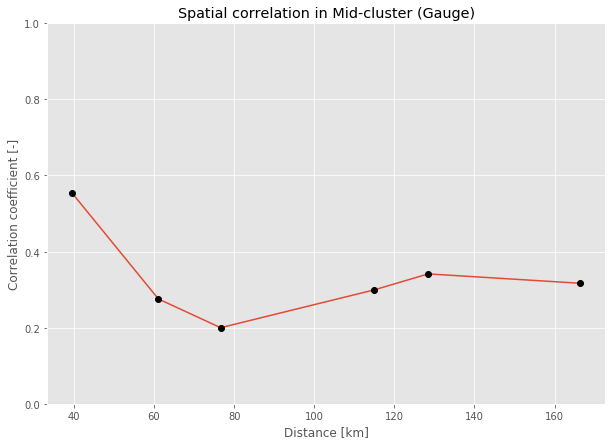

In [155]:
plt.figure(figsize=(10, 7))

plt.plot(dist, r)
plt.plot(dist, r, 'o', color='black')


plt.ylabel('Correlation coefficient [-]')
plt.xlabel('Distance [km]')
plt.ylim(0, 1)
# plt.xlim(0, 150)

plt.title(f'Spatial correlation in Mid-cluster (Gauge)')

plt.savefig('DataFigures/Spatial correlation in Mid-cluster (Gauge).png');